# 0. Setup

In [1]:
! pip install transformers newspaper3k datasets urllib3==1.25.11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.3 MB/s 
     |████████████████████████████████| 211 kB 78.5 MB/s 
     |████████████████████████████████| 452 kB 76.0 MB/s 
     |████████████████████████████████| 127 kB 80.1 MB/s 
     |████████████████████████████████| 182 kB 76.8 MB/s 
     |████████████████████████████████| 7.6 MB 57.5 MB/s 
     |████████████████████████████████| 81 kB 10.2 MB/s 
     |████████████████████████████████| 7.4 MB 68.8 MB/s 
     |████████████████████████████████| 93 kB 3.1 MB/s 
     |████████████████████████████████| 132 kB 51.9 MB/s 
     |████████████████████████████████| 212 kB 83.1 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=fd61f61d0a63627b3d46501f83c0c4e5df3836bee9482489ba60d3711afca11d
  Stored in directory: /root/.cache/pip/wheels/99/74/83/8fac1c8d9c648cfabebbbffe97a889f6624817f3aa0bbe6c

In [2]:
import urllib3
import os
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from newspaper import Article
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import datasets
from datasets import load_dataset
import transformers
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import spacy

In [4]:
import spacy

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'
os.chdir(MAIN_FOLDER)

# 0.1 Defining variables

In [7]:
URL = 'url'
TARGET = 'label'
TEXT = 'text'

# Constants that will disappear when transitioning to functions:
# Cell 1

html_folder = HTML_FOLDER
# Cell 2

# Name of the file that will origin 'df_text1'
csv_path1 = 'activities_unlabeled.csv'
usecols1 = ['File Name', 'Label']

nlp = spacy.load('en_core_web_sm')

In [8]:
# Name of the file that will origin 'df_text2'
csv_path = 'activities_labeled13.csv'
usecols = ['url', 'true_label']

In [9]:
# Cell 8

# Defining the classes that we are going to be working with and their encoded labels
labels_encoded = {'Article': 0, 'Blog': 1, 'Event': 2, 'Webinar': 3, 'PR': 4, 'MISC': 5}

labels_decoded = {y: x for x, y in labels_encoded.items()}
maximum_classes = len(labels_encoded)

In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9A-Za-z #+_]')
STOPWORDS = set(stopwords.words('english'))

# 0.2 Functions

## Saving/loading variables

In [11]:
def save_variable(variable, variable_name):
  with open(f'./saved_variables/{variable_name}.pickle', 'wb') as f:
    pickle.dump(variable, f)

def read_variable(variable_name):
  with open(f'./saved_variables/{variable_name}.pickle', 'rb') as f:
    variable = pickle.load(f)
  return variable

def check_if_exists(variable_name):
  if variable_name in globals():
    print(f'Variable "{variable_name}" exists.')
  else:
    print(f'Variable "{variable_name}" does not exist.')

## Preprocessing

In [12]:
def get_most_common_tokens(df, column, amount=10):
  tokenized = [word_tokenize(string) for string in df[column]]
  flat_list = [item for sublist in tokenized for item in sublist]
  return Counter(flat_list).most_common(amount)

## Modeling

In [13]:
def fit_model(clf, X_train_transformed, y_train):
  clf.fit(X_train_transformed, y_train)
  return clf


def predict(clf, X_test_transformed):
  y_pred = clf.predict(X_test_transformed)
  return y_pred


def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy


def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression, not SVM)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{labels_decoded[clf.classes_[i]]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')
      

def print_confusion_matrix(y_test, y_pred, with_report=False):

  accuracy = get_accuracy(y_test, y_pred)

  y_test = list(map(lambda x: labels_decoded[x], y_test))
  y_pred = list(map(lambda x: labels_decoded[x], y_pred))

  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title(f'Confusion matrix - acc {accuracy:.3f}', size=15)
  plt.show()
  if with_report:
    print('\n' + classification_report(y_test, y_pred))


def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy


def print_train_val_len_start(train_index, val_index):
    print(f'TRAIN index len: {len(train_index)}, start: {train_index[:3]}, '
          f'\tVALIDATION index len: {len(val_index)}, start: {val_index[:3]}')

def print_val_scores(scores, extra_info=False):
    print(f'Cross validation scores: mean: {np.mean(scores):.3f}, all: {[round(score, 3) for score in scores]}')
    if extra_info:
        print('(std: {np.std(scores):.3f}, min: {min(scores):.3f}, max: {max(scores):.3f})')


def create_misclassified_df(X_test, y_test, y_pred):
  if type(y_pred) == np.ndarray and type(y_test) == pd.core.series.Series:
    y_pred = pd.Series(y_pred, index=y_test.index) # setting y_pred to same type and indexes as y_test
  
  mask = y_pred != y_test
  
  if type(y_pred) == np.ndarray and type(y_test) == np.ndarray:
    y_pred = pd.Series(y_pred)
    y_test = pd.Series(y_test)
    
  df = X_test.copy()[mask]
  df['y_true'] = y_test[mask].replace(labels_decoded)
  df['y_pred'] = y_pred[mask].replace(labels_decoded) 
  return df
  

# 0.3 (Optional) Load df_text1

In [14]:
check_if_exists('df_text1')
df_text1 = read_variable('df_text1')
check_if_exists('df_text1')
df_text1

Variable "df_text1" does not exist.
Variable "df_text1" exists.


,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


# 0.4 (Optional) Load "df_text2"

In [15]:
VARIABLE = 'df_text2'

check_if_exists(VARIABLE)
print(f'Reading variable "{VARIABLE}"...')
df_text2 = read_variable(VARIABLE)
check_if_exists(VARIABLE)

Variable "df_text2" does not exist.
Reading variable "df_text2"...
Variable "df_text2" exists.


In [16]:
df_text2

,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://sfesummit.com/,12th Annual Sales Force Effectiveness & Digita...,Event
3,http://www.obviohealth.com/events/informa-1-2021,ObvioHealth. MAGI Clinical Research Conference...,Webinar
4,http://www.genesisconference.com/,Home : Genesis 2022.,Event
...,...,...,...
1014,http://www.entrepreneur.com/article/400416,Veeva Systems is a Top Stock for 2022. Veeva S...,Article
1015,http://www.koreabiomed.com/news/articleView.ht...,Medidata’s Acorn AI solution raises clinical t...,Article
1016,http://www.finsmes.com/2021/10/science-37-clos...,Science 37 Closes Business Combination with Li...,?
1017,http://seekingalpha.com/article/4450420-labora...,Laboratory Corp: 18%-20% Yearly Return With Sa...,-


# 0.5 (Optional) Load "df_text"

In [17]:
VARIABLE = 'df_text'

check_if_exists(VARIABLE)
print(f'Reading variable "{VARIABLE}"...')
df_text = read_variable(VARIABLE)
check_if_exists(VARIABLE)

Variable "df_text" does not exist.
Reading variable "df_text"...
Variable "df_text" exists.


# 0.6 (Optional) Create and save "df_text1" - general preprocessing of html

In [ ]:
# Important cell # 1
html_files = os.listdir(html_folder)

In [ ]:
# Important cell # 2

df1 = pd.read_csv(csv_path1, usecols=usecols)
df1.rename(columns={usecols1[0]: 'filename', usecols1[1]: TARGET}, inplace=True)
df1 = df1[~df1['filename'].isna()]
print(f'Original shape: {df1.shape}')
df1 = df1[df1[TARGET] != '-']
df1.reset_index(drop=True, inplace=True)
print(f'Final shape: {df1.shape}')

In [ ]:
# Important cell # 3
df1[TARGET].value_counts(normalize=False)

In [ ]:
# Important cell # 4
filenames = df1['filename'].values
htmls = list()

for i, filename in enumerate(filenames):
  try:
    with open(f'{HTML_FOLDER}{filename}') as f:
      html = f.read()
      htmls.append(html)
  except FileNotFoundError:
    print(f'File {i} not found: "{filename}"')

In [ ]:
# Important cell # 5
toi_articles = list()

for html in htmls:
  toi_article = Article(url = ' ', language = "en")
  toi_article.set_html(html)
  toi_article.parse()
  toi_article.nlp()
  toi_articles.append(toi_article)

In [ ]:
# Important cell # 6
y = df1[TARGET].tolist()

In [ ]:
# Important cell # 7
summaries = [(toi_article.title + '. ' + toi_article.text).replace('\n', ' ') for toi_article in toi_articles]

In [ ]:
len(y), len(summaries)

In [ ]:
# Important cell # 7.5
df_text1 = pd.DataFrame({TEXT: summaries, TARGET: y})

In [ ]:
df_text1

In [ ]:
save_variable(df_text1, 'df_text1')

# 0.7 (Optional) Create and save "df_text2" - general preprocessing of urls

In [ ]:
csv_path

'activities_labeled13.csv'

In [ ]:
df_data = pd.read_csv(csv_path, usecols=usecols)
df_data.rename(columns={usecols[1]: TARGET}, inplace=True)
df_data = df_data[~df_data[TARGET].isna()]
df_data.reset_index(drop=True, inplace=True)

# All sections of blogs labeled as 'MISC/Blog?' become part of 'MISC'.
df_data.loc[df_data[TARGET] == 'MISC/Blog?', TARGET] = 'MISC'

In [ ]:
VARIABLE = 'labels_old'

try:
  labels_old = read_variable(VARIABLE)
  print(f'Variable {VARIABLE} already existed and contains {len(labels_old)} elements.')
except FileNotFoundError:
  labels_old = list()
  print(f'Variable {VARIABLE} was just created and contains {len(labels_old)} elements.')

Variable labels_old already existed and contains 953 elements.


In [ ]:
VARIABLE = 'indexes_old'

try:
  indexes_old = read_variable(VARIABLE)
  print(f'Variable {VARIABLE} already existed and contains {len(indexes_old)} elements.')
except FileNotFoundError:
  indexes_old = list()
  print(f'Variable {VARIABLE} was just created and contains {len(indexes_old)} elements.')

Variable indexes_old already existed and contains 953 elements.


In [ ]:
VARIABLE = 'texts_old'

try:
  texts_old = read_variable(VARIABLE)
  print(f'Variable {VARIABLE} already existed and contains {len(texts_old)} elements.')
except FileNotFoundError:
  texts_old = list()
  print(f'Variable {VARIABLE} was just created and contains {len(texts_old)} elements.')

Variable texts_old already existed and contains 953 elements.


In [ ]:
VARIABLE = 'urls_old'

try:
  urls_old = read_variable(VARIABLE)
  print(f'Variable {VARIABLE} already existed and contains {len(urls_old)} elements.')
except FileNotFoundError:
  urls_old = list()
  print(f'Variable {VARIABLE} was just created and contains {len(urls_old)} elements.')

Variable urls_old already existed and contains 1158 elements.


In [ ]:
urls = df_data['url']

# We use a mask to select the elements that are in 'urls' and not in 'urls_old' to create 'urls_new'.
mask = np.isin(urls, urls_old)
urls_new = urls[~mask]
print(f'There are {len(urls_new)} URLs to read.')

There are 88 URLs to read.


In [ ]:
# Important cell # 5
texts_new = list()
indexes_new = list()

idx_label_to_remove = list()
idx_label = 0

for i, url in enumerate(urls_new, len(urls_old)):
  try:
    toi_article = Article(url = url, language = "en")
    toi_article.download()
    toi_article.parse()
    toi_article.nlp()
    text = (toi_article.title + '. ' + toi_article.text).replace('\n', ' ')
    texts_new.append(text)
    indexes_new.append(i)
    print(f'{i}: url "{url}" read successfully.')
  except Exception:
    idx_label_to_remove.append(idx_label)
    print(f'{i}: ERROR: url "{url}" was not read successfully.')
  
  idx_label += 1

1158: url "http://seekingalpha.com/news/3739294-iqvia-partners-with-nrx-pharma-to-support-regulatory-pathway-for-covid-19-therapy" read successfully.
1159: url "http://www.healthcareitnews.com/news/emea/iqvia-partners-saudi-data-and-artificial-intelligence-authority-sdaia" read successfully.
1160: url "http://www.businesswire.com/news/home/20210805005130/en/Verily-Opens-New-RD-Center-in-Israel-Focused-on-the-Application-of-AI-in-Healthcare/?feedref=JjAwJuNHiystnCoBq_hl-RLXHJgazfQJNuOVHefdHP-D8R-QU5o2AvY8bhI9uvWSD8DYIYv4TIC1g1u0AKcacnnViVjtb72bOP4-4nHK5ieT3WxPE8m_kWI77F87CseT" read successfully.
1161: url "http://www.streetinsider.com/Press+Releases/StudyKIK%2C+A+Global+Clinical+Trial+Patient+Recruitment+%26amp%3B+Retention+Technology+Company%2C+Appoints+Kevin+Vass+as+Chief+Financial+Officer/18389562.html" read successfully.
1162: ERROR: url "http://www.bizjournals.com/sanfrancisco/news/2021/12/21/verily-google-andy-conrad-stephen-gillett.html?ana=RSS&s=article_search" was not read succ

In [ ]:
print(f'When reading the new URLs, {len(urls_new) - len(indexes_new)} of them threw an error and could not be read.')

When reading the new URLs, 22 of them threw an error and could not be read.


In [ ]:
labels_new = df_data.loc[urls_new.index, TARGET]

In [ ]:
assert (labels_new == df_data.loc[labels_new.index, TARGET]).all()

In [ ]:
labels_new.reset_index(drop=True, inplace=True)
labels_new = labels_new.drop(idx_label_to_remove).tolist()

In [ ]:
labels = labels_old + labels_new
indexes = indexes_old + indexes_new
texts = texts_old + texts_new
# We change the type and order of urls, deleting also the ones repeated in 'urls_old' and 'urls_new'
urls = urls_old + urls_new.tolist()

In [ ]:
assert len(texts) == len(pd.Series(urls).loc[indexes]) == len(indexes) == len(labels)

In [ ]:
df_text2 = pd.DataFrame({
    URL: pd.Series(urls).loc[indexes],
    TEXT: texts,
    TARGET: labels,
    }).reset_index(drop=True)

In [ ]:
save_variable(labels, 'labels_old')
save_variable(indexes, 'indexes_old')
save_variable(texts, 'texts_old')
save_variable(urls, 'urls_old')
save_variable(df_text2, 'df_text2')

# 0.8 (Optional) Create and save "df_text"

In [ ]:
if df_text2[URL].duplicated().sum() == 0:
  print(f'There are no duplicate URLs or texts in df_text2.')
else:
  original_amount = df_text2.shape[0]
  df_text2 = df_text2[~df_text2[URL].duplicated()]
  print(f"{original_amount - df_text2.shape[0]} URLs were duplicates and hence deleted.")
  assert df_text2[URL].duplicated().sum() == 0

69 URLs were duplicates and hence deleted.


In [ ]:
df_text = pd.concat([df_text1, df_text2]).reset_index(drop=True)

In [ ]:
if df_text[TEXT].duplicated().sum() == 0:
  print(f'There are no duplicate URLs or texts in df_text.')
else:
  original_amount = df_text.shape[0]
  df_text = df_text[~df_text[TEXT].duplicated()]
  print(f"{original_amount - df_text.shape[0]} texts were duplicates and hence deleted.")
  assert df_text[TEXT].duplicated().sum() == 0

59 texts were duplicates and hence deleted.


In [ ]:
# import seaborn as sns
# values = df_text['text'].str.split().str.len()
# sns.boxplot(x=values)
# plt.show()

In [ ]:
df_text = df_text[~df_text[TEXT].str.contains('404 status code')]

In [ ]:
THRESHOLD1 = 50
THRESHOLD2 = 51

characters = df_text[TEXT].str.split().str.len()
df_text.loc[(characters >= THRESHOLD1) & (characters <= THRESHOLD2), TEXT].tolist()

['Carlisle Law: Expert creditors’ rights legal counsel, proven results. Who We Are  Since 1970, Carlisle Law has built our practice on the aggressive defense of creditors’ rights. A full-service firm, we are focused on the representation of lenders, mortgagees, landlords, financial institutions, investors, tax certificate holders, and distressed asset purchasers.',
 'Website Performance Testing and Monitoring. See how your page loads on different devices  Test your page on a real Android device or on over 30 different Simulated Device options.  Analyze your performance with iPhones, iPads, Samsung Galaxy/Note, Google Nexus/Pixel phones, and other popular devices.  Mobile Testing only available with GTmetrix PRO.',
 'Immuno-Oncology 360°. Setting new standards in information exchange for the pharmaceutical and biotech industry  Designed by lead Advisors Dr Axel Hoos (GSK) and Dr James Gulley (NCI), the program provided a unique 360-degree approach addressing the business aspects, clinic

In [ ]:
# By analizing the texts, errors started to show up in the ones that had below 51 words.

fraction_ignored = 0.165 # We will lose 16.5% of our data

values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(fraction_ignored)
minimum_words

51.0

In [ ]:
values.describe()[['25%', '75%']]

25%     80.0
75%    593.0
Name: text, dtype: float64

In [ ]:
df_text[TARGET].value_counts()

Webinar                  208
Event                    206
Blog                     202
Home Page                196
PR                       151
MISC                     110
Article                   87
-                         57
Product Page              44
?                         14
Podcast                   14
White Paper               13
Digital event             11
Video Content              9
Education                  6
Article/PR                 5
Home Page/Event            3
Webcast                    3
About Page                 2
Press Release              2
PR (w Blog label)          2
Virtual Summit             1
Publication                1
Webinar ended              1
Past webinar               1
LinkedIn                   1
Google Form for Event      1
Name: label, dtype: int64

In [ ]:
df_text.shape

(1351, 3)

In [ ]:
if maximum_classes:
  df_text = df_text[df_text[TARGET].isin(labels_encoded)]

df_text.reset_index(drop=True, inplace=True)

In [ ]:
df_text.shape

(964, 3)

In [ ]:
# Important cell # 8

# If the text a URL contains is below this threshold, it gets discarded
minimum_words = 51

if minimum_words:
  df_text = df_text[df_text[TEXT].str.split().str.len() >= minimum_words]

In [ ]:
df_text.shape

(857, 3)

In [ ]:
# DISTILBERT_EMBEDDINGS = 768
# (df_text[TEXT].str.split().str.len() > DISTILBERT_EMBEDDINGS).sum()

In [ ]:
# df_text.loc[df_text[TEXT].str.split().str.len() > DISTILBERT_EMBEDDINGS, TEXT].str.split().str.len()

In [ ]:
df_text.shape[0]

857

In [ ]:
df_text[TARGET].value_counts()

Blog       198
Event      174
Webinar    172
PR         150
Article     86
MISC        77
Name: label, dtype: int64

In [ ]:
# Important cell # 8
def clean_text(text):
    """
    @text: a string
    Returns a modified version of the initial string
    """
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

print(f"Amount of words before cleaning text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['cleaned_text'] = df_text[TEXT].apply(clean_text)
print(f"Amount of words after cleaning text: {df_text['cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text['cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning text: 588737
Amount of unique words before cleaning text: 50526

Amount of words after cleaning text: 367289
Amount of unique words before cleaning text: 30237


In [ ]:
def lemmatize_text(text):
    lemmatized = ' '.join(token.lemma_ for token in nlp(text))
    return lemmatized

print(f"Amount of words before lemmatizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_text'] = df_text[TEXT].apply(lemmatize_text)
print(f"Amount of words after lemmatizing text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before lemmatizing text: 588737
Amount of unique words before lemmatizing text: 50526

Amount of words after lemmatizing text: 707420
Amount of unique words before lemmatizing text: 23242


In [ ]:
print(f"Amount of words before cleaning lemmatized text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_cleaned_text'] = df_text['lemmatized_text'].apply(clean_text)
print(f"Amount of words after cleaning lemmatized text: {df_text['lemmatized_cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning lemmatized text: 707420
Amount of unique words before cleaning lemmatized text: 23242

Amount of words after cleaning lemmatized text: 351888
Amount of unique words before cleaning lemmatized text: 21922


In [ ]:
df_text.head(3) # df with different techniques for preprocessing of the text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,NaN,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...
1,Write For Us. Want to Write for Us? Digital L...,MISC,NaN,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,NaN,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...


In [ ]:
df_text.loc[0, TEXT]

"2020 User Summit. 2020 User Summit  *UPDATE - March 12th, 2020*  With the ongoing coverage of the seriousness of the global outbreak of the COVID-19 virus and the potential effects, we want you to know that our priority is to keep our Summit attendees safe and informed.  While our AC User Summit is just more than a month away, we are sensitive to our clients' travel and safety. Out of an abundance of caution and concern, we have decided to cancel the 2020 User Summit in the best interest of all involved.  While we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.  Registration fees will be credited back to all clients who have registered for the Summit.  Thank you for your patience and understanding as we work through unprecedented times together."

In [ ]:
# df_text.loc[0, 'lemmatized_text']

In [ ]:
# df_text.loc[0, 'lemmatized_cleaned_text']

In [ ]:
def lemmatize_text2(text):
  lemmatized = ' '.join(token.text.lower() for token in nlp(text))
  return lemmatized

df_text['w2v_text'] = df_text[TEXT].apply(lemmatize_text2)

In [ ]:
# print(f"Amount of words before tokenizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before tokenizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
# tokenized = [word_tokenize(string) for string in df_text[TEXT]]
# df_text['tokenized'] = list(map(lambda x: ' '.join(x), tokenized))
# print(f"Amount of words after tokenizing text: {df_text['tokenized'].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before tokenizing text: {np.unique(np.concatenate(df_text['tokenized'].str.split().values, axis=0)).shape[0]}")

In [ ]:
save_variable(df_text, 'df_text')

In [ ]:
# df_text = read_variable('df_text')

In [ ]:
df_text[TARGET].value_counts()

Blog       198
Event      174
Webinar    172
PR         150
Article     86
MISC        77
Name: label, dtype: int64

# 0.9 Further EDA and preprocessing on "df_text"

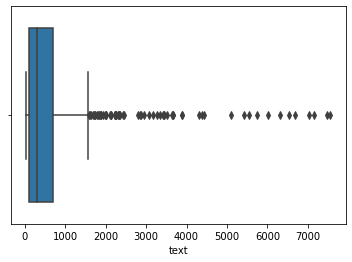

In [ ]:
import seaborn as sns
values = df_text['text'].str.split().str.len()
sns.boxplot(x=values)
plt.show()

values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(0.15) # we ignore 15 % of the data, making sure the threshold ignores all outliers (< 0.25)
minimum_words

values.describe()[['25%', '75%']]

In [ ]:
values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(0.15) # we ignore 15 % of the data, making sure the threshold ignores all outliers (< 0.25)
minimum_words

72.0

In [ ]:
values.describe()[['25%', '75%']]

25%    110.5
75%    697.5
Name: text, dtype: float64

In [ ]:
df_text

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,Write For Us. Want to Write for Us? Digital L...,MISC,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
1,"Write for Us. Yes, you. We’re always looking f...",MISC,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
2,FAQs for some new features available in the Be...,Blog,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
3,The Web Credibility Project. Our research in W...,Home Page,The Web Credibility Project Our research Web c...,the web Credibility Project . our research in ...,web Credibility Project research web credibili...,the web credibility project . our research in ...
4,Model DJs for Retail. DJPeoples is the nation’...,MISC,Model DJs Retail DJPeoples nations premier age...,Model dj for Retail . djpeople be the nation ’...,Model dj Retail djpeople nation premier agency...,model djs for retail . djpeoples is the nation...
...,...,...,...,...,...,...
326,Teach Yourself Visually Search Engine Optimiza...,Product Page,Teach Yourself Visually Search Engine Optimiza...,teach yourself Visually Search Engine Optimiza...,teach Visually Search Engine Optimization whet...,teach yourself visually search engine optimiza...
327,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page,The Art SEO 2nd Edition Four acknowledged expe...,"the art of seo , 2nd Edition . four acknowledg...",art seo 2nd Edition four acknowledge expert se...,"the art of seo , 2nd edition . four acknowledg..."
328,Submit A Guest Post – Guidelines (Write for Us...,MISC,Submit A Guest Post Guidelines Write Us We acc...,submit a Guest Post – Guidelines ( write for U...,submit Guest Post Guidelines write Us accept G...,submit a guest post – guidelines ( write for u...
329,Fully Managed Magento Hosting — JetRails. Full...,MISC,Fully Managed Magento Hosting JetRails Fully M...,fully manage Magento Hosting — JetRails . full...,fully manage Magento Hosting JetRails fully ma...,fully managed magento hosting — jetrails . ful...


In [ ]:
df_text['w2v_text'].tolist()

['write for us . want to write for us ?   digital lamp , is one of the fastest - growing tech blog . we allow you an endless opportunity for new authors , technical content writers , freelance content writing professionals , and guest writers to technology + “ write for us ” + guest post ( contribute or submit guest post article ) about the topics related to technology , business , internet , gadgets , digital marketing , security , seo , tech blog , etc .   technology is the way progressive for online businesses . why not share your expertise by guest blogging on technology blogs to highlight awareness of this emerging trend .   you will obtain the benefits of being a guest blogger by establishing yourself as an authority in the industry . on top of that , you will build social proof , create a robust online presence , develop new relationships with bloggers and readers and rank better in the search engines .   all you need to do is meet the criteria set out by the technology blogs be

In [ ]:
df_text[TARGET].value_counts()

0    128
7    124
1    110
6     85
2     79
5     66
4     55
3     44
Name: label, dtype: int64

In [ ]:
# df_text[TARGET].replace({1: 5}, inplace=True) # make Blog and Article a single category

In [ ]:
df_text[TARGET].value_counts()

5    176
0    128
7    124
6     85
2     79
4     55
3     44
Name: label, dtype: int64

In [ ]:
labels_encoded

{'Home Page': 0,
 'Blog': 1,
 'MISC': 2,
 'Product Page': 3,
 'Event': 4,
 'Article': 5,
 'Webinar': 6,
 'PR': 7}

# 1. Bag of Words approach

## Preprocessing

In [18]:
labels_encoded

{'Article': 0, 'Blog': 1, 'Event': 2, 'Webinar': 3, 'PR': 4, 'MISC': 5}

In [19]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

In [20]:
# # Working only with df_text2
# df_text = df_text[(df_text['url'] != 'Not provided') & (df_text[TARGET].isin([7, 6, 4, 1, 5]))]

In [21]:
df_text[TARGET].value_counts()

1    198
2    174
3    172
4    150
0     86
5     77
Name: label, dtype: int64

In [22]:
df_text.shape[0]

857

In [23]:
# df_positive = df_text[df_text[TARGET] != 5]
# df_negative = df_text[df_text[TARGET] == 5]

# Cell 9
test_size = 0.2
random_state = 0

# Important cell # 9
column_used = 'lemmatized_cleaned_text'

# X = df_positive[[column_used]]
# y = df_positive[TARGET]
X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state
                                                    )

# X_misc = df_negative[[column_used]]
# y_misc = df_negative[TARGET]
# X_test = pd.concat([X_test, X_misc])
# y_test = pd.concat([y_test, y_misc])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((685, 1), (172, 1), (685,), (172,))

In [24]:
# Important cell # 10
majority_class = y_train.value_counts().index[0]
baseline_accuracy = sum(y_test == majority_class) / len(y_test)
print(f'Baseline accuracy: {baseline_accuracy:.4f}')

Baseline accuracy: 0.2326


In [25]:
get_most_common_tokens(df=df_text, column='lemmatized_cleaned_text', amount=10)

[('use', 2189),
 ('patient', 1949),
 ('clinical', 1801),
 ('trial', 1733),
 ('datum', 1646),
 ('company', 1532),
 ('I', 1511),
 ('make', 1432),
 ('content', 1423),
 ('need', 1275)]

In [26]:
# Important cell # 11
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_tr = vectorizer.fit_transform(X_train[column_used])
X_test_tr = vectorizer.transform(X_test[column_used])

In [27]:
X_train_tr.toarray().shape, X_test_tr.toarray().shape

((685, 440643), (172, 440643))

In [28]:
# import string

# # STOPWORDS = stop_words.ENGLISH_STOP_WORDS

# #Function for basic cleaning/preprocessing texts
# def clean(doc):
#     # Removal of punctuation marks (.,/\][{} etc) and numbers
#     doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
#     # Removal of stopwords
#     doc = " ".join([token for token in doc.split() if token not in STOPWORDS])
#     return doc.lower()

# string.punctuation

## Modeling

In [29]:
clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=3000,
                                              class_weight='balanced')), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)), 
    ('KNN 5', KNeighborsClassifier(n_neighbors=5)),
    ('SVM C1', SVC(C=1, 
                   class_weight='balanced')),
    ('MultinomialNB', MultinomialNB())
]

In [30]:
for clf in clfs:
  print(f'\nStratifiedKFold - classifier: {clf[0]}:\n')
  skf = StratifiedKFold(n_splits=5)
  for train_index, val_index in skf.split(X_train_tr, y_train):
      print_train_val_len_start(train_index, val_index)
      print(f'\tMean y: TRAIN: {y_train.iloc[train_index].mean():.3f},\tVALIDATION: {y_train.iloc[val_index].mean():.3f}')

  scores = cross_val_score(clf[1], 
                          X_train_tr,
                          y_train,
                          cv=5)
  
  print_val_scores(scores)


StratifiedKFold - classifier: LogisticRegression:

TRAIN index len: 548, start: [121 122 125], 	VALIDATION index len: 137, start: [0 1 2]
	Mean y: TRAIN: 2.389,	VALIDATION: 2.394
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [121 122 125]
	Mean y: TRAIN: 2.394,	VALIDATION: 2.372
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [255 258 260]
	Mean y: TRAIN: 2.387,	VALIDATION: 2.401
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [364 370 371]
	Mean y: TRAIN: 2.387,	VALIDATION: 2.401
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [481 498 512]
	Mean y: TRAIN: 2.392,	VALIDATION: 2.380
Cross validation scores: mean: 0.750, all: [0.745, 0.788, 0.745, 0.657, 0.818]

StratifiedKFold - classifier: RandomForest:

TRAIN index len: 548, start: [121 122 125], 	VALIDATION index len: 137, start: [0 1 2]
	Mean y: TRAIN: 2.389,	VALIDATION: 2.394
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index

In [31]:
y_train.value_counts(normalize=True)

1    0.230657
2    0.202920
3    0.200000
4    0.175182
0    0.100730
5    0.090511
Name: label, dtype: float64

In [32]:
y_test.value_counts(normalize=True)

1    0.232558
3    0.203488
2    0.203488
4    0.174419
0    0.098837
5    0.087209
Name: label, dtype: float64

Checking results on the test set:

In [33]:
# clf, clf_name, val_acc = get_best_clf(clfs, X_train, X_test, y_train, y_test)
# print(f'Best classifier: {clf_name}, validation accuracy: {val_acc:.3f}, '
#       f'test accuracy: {clf.score(X_test, y_test):.3f}')

clf, clf_name, test_acc = get_best_clf(clfs, X_train_tr, X_test_tr, y_train, y_test)
print(f'Best classifier: {clf_name}, test accuracy: {test_acc:.3f}')

                    accuracy
clf                         
LogisticRegression  0.755814
RandomForest        0.674419
KNN 5               0.645349
SVM C1              0.686047
MultinomialNB       0.529070
Best classifier: LogisticRegression, test accuracy: 0.756


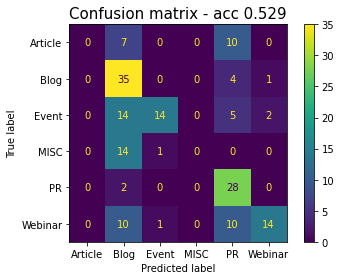


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        17
        Blog       0.43      0.88      0.57        40
       Event       0.88      0.40      0.55        35
        MISC       0.00      0.00      0.00        15
          PR       0.49      0.93      0.64        30
     Webinar       0.82      0.40      0.54        35

    accuracy                           0.53       172
   macro avg       0.44      0.43      0.38       172
weighted avg       0.53      0.53      0.47       172



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
clf = fit_model(MultinomialNB(),
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

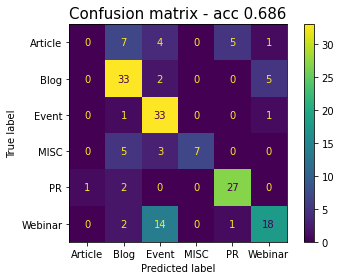


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        17
        Blog       0.66      0.82      0.73        40
       Event       0.59      0.94      0.73        35
        MISC       1.00      0.47      0.64        15
          PR       0.82      0.90      0.86        30
     Webinar       0.72      0.51      0.60        35

    accuracy                           0.69       172
   macro avg       0.63      0.61      0.59       172
weighted avg       0.65      0.69      0.65       172



In [35]:
clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

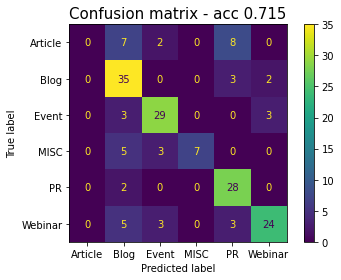


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        17
        Blog       0.61      0.88      0.72        40
       Event       0.78      0.83      0.81        35
        MISC       1.00      0.47      0.64        15
          PR       0.67      0.93      0.78        30
     Webinar       0.83      0.69      0.75        35

    accuracy                           0.72       172
   macro avg       0.65      0.63      0.62       172
weighted avg       0.67      0.72      0.68       172



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced'
                                   ), 
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

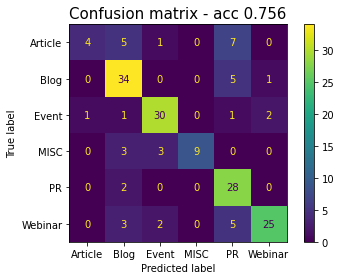


              precision    recall  f1-score   support

     Article       0.80      0.24      0.36        17
        Blog       0.71      0.85      0.77        40
       Event       0.83      0.86      0.85        35
        MISC       1.00      0.60      0.75        15
          PR       0.61      0.93      0.74        30
     Webinar       0.89      0.71      0.79        35

    accuracy                           0.76       172
   macro avg       0.81      0.70      0.71       172
weighted avg       0.79      0.76      0.74       172



In [37]:
clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced'
    ), 
    X_train_tr, 
    y_train,
    )

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [38]:
X_train_tr.toarray().shape

(685, 440643)

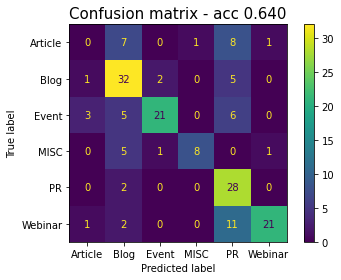


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        17
        Blog       0.60      0.80      0.69        40
       Event       0.88      0.60      0.71        35
        MISC       0.89      0.53      0.67        15
          PR       0.48      0.93      0.64        30
     Webinar       0.91      0.60      0.72        35

    accuracy                           0.64       172
   macro avg       0.63      0.58      0.57       172
weighted avg       0.67      0.64      0.62       172



In [39]:
clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced',
    solver='liblinear', # default: 'lbfgs' 
    penalty='l1', # default: 'l2'
    ), 
    X_train_tr, 
    y_train,
    )

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [40]:
print_important_features(clf, features=5)

Class "Article" - 5 most important features: ['000' 'poolside' 'pooling take place' 'pooling take'
 'pooling result manage']
Class "Blog" - 5 most important features: ['clinical' 'iqvia' '000' 'pooling result manage' 'pooling result']
Class "Event" - 5 most important features: ['patient' 'iqvia' 'trial' 'poolside' 'pooling take place']
Class "Webinar" - 5 most important features: ['000' 'pooling take' 'pooling result manage' 'pooling result'
 'pooling offer high']
Class "PR" - 5 most important features: ['000' 'pooling take place' 'pooling take' 'pooling result manage'
 'pooling result']
Class "MISC" - 5 most important features: ['patient' '000' 'pooling take place' 'pooling take'
 'pooling result manage']


In [41]:
misclassified_df = create_misclassified_df(X_test, y_test, y_pred)
assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
misclassified_df

,lemmatized_cleaned_text,y_true,y_pred
932,IQVIA IQV buy remain Q2 Solutions Stake Ups EP...,PR,Blog
821,reduce Clinical Trial Costs use decentralize c...,Blog,PR
713,CVS ink deal Medable enroll patient clinical t...,Article,PR
680,California end Verily covid19 testing partners...,Article,PR
880,Power Patient Centricity Rare Disease Studies ...,Blog,PR
...,...,...,...
308,outsource Clinical Trials West Coast 2023 comp...,Event,Article
404,10 000 day Transform Sept 21 23 2021 first day...,Event,Blog
563,post pandemic change strategy Digital Transfor...,Webinar,PR
909,Springboard success 5 Kickoff Meeting Tips Suc...,Blog,Article


In [42]:
INDEX = 0
true_index = misclassified_df.index[INDEX]
misclassified_df.loc[true_index, 'lemmatized_cleaned_text']

'IQVIA IQV buy remain Q2 Solutions Stake Ups EPS View page authorize sponsor otherwise approve endorse company represent herein company logo represent herein trademark Microsoft Corporation Dow Jones Company Nasdaq Inc Forbes Media LLC Investor Business Daily Inc Morningstar Inc Copyright 2022 Zacks Investment Research 10 Riverside Plaza Suite # 1600 Chicago IL 60606 center everything strong commitment independent research share profitable discovery investor dedication give investor trading advantage lead creation prove Zacks Rank stock rating system since 1988 double SP 500 average gain +2451 per year return cover period January 1 1988 September 12 2022 Zacks Rank stock rating system return compute monthly base beginning month end month Zacks Rank stock price plus dividend receive particular month simple equally weight average return Zacks Rank stock calculate determine monthly return monthly return compound arrive annual return Zacks Rank stock include Zacks hypothetical portfolio be

# 2. Word2Vec approach

In [ ]:
# Deleting heavy variables no longer useful:
try:
  del X_train_tr
  del X_test_tr
except NameError:
  pass

In [ ]:
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
save_variable(w2v_model, 'w2v_model')

In [ ]:
w2v_model.word_vec("test").shape

(300,)

In [ ]:
print("Shape of embedding vector", w2v_model["Natural"].shape)
print("First 20 numbers in the embedding of the word Natural\n\n", w2v_model["Natural"][:20])

Shape of embedding vector (300,)
First 20 numbers in the embedding of the word Natural

 [-0.22753906 -0.07617188 -0.06787109 -0.1015625   0.20214844  0.12890625
  0.1796875  -0.11035156  0.01123047  0.01794434  0.12402344  0.11132812
 -0.3359375  -0.01104736 -0.16015625 -0.16113281 -0.13769531  0.4296875
 -0.03979492  0.05297852]


In [ ]:
df_text

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,4,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,2,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",2,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,1,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,5,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...
542,"Veeva Research Sites Forum, North America. Cli...",4,Veeva Research Sites Forum North America Clini...,"Veeva Research Sites Forum , North America . C...",Veeva Research Sites Forum North America Clini...,"veeva research sites forum , north america . c..."
543,Rethinking the Life Sciences Training Technolo...,6,Rethinking Life Sciences Training Technology E...,rethink the Life Sciences Training Technology ...,rethink Life Sciences Training Technology Ecos...,rethinking the life sciences training technolo...
544,Advancing Meaningful Remote Digital Endpoints ...,6,Advancing Meaningful Remote Digital Endpoints ...,advance Meaningful Remote Digital Endpoints fo...,advance Meaningful Remote Digital Endpoints Ra...,advancing meaningful remote digital endpoints ...
545,How Technology is Transforming Clinical Endpoi...,6,How Technology Transforming Clinical Endpoint ...,how Technology be Transforming Clinical Endpoi...,Technology Transforming Clinical Endpoint Adju...,how technology is transforming clinical endpoi...


In [ ]:
list_of_lists = df_text['w2v_text'].str.split().tolist()

In [ ]:
#Function that takes in the input text dataset in form of list of lists where each sentence is a list of words all the sentences are 
#inside a list
def embedding_feats(list_of_lists, DIMENSION, w2v_model):
    zeros_vector = np.zeros(DIMENSION)
    feats = []
    missing = set()
    missing_sentences = set()
    #Traverse over each sentence
    for tokens in tqdm(list_of_lists):
        # Initially assign zeroes as the embedding vector for the sentence
        feat_for_this = zeros_vector
        #Count the number of words in the embedding for this sentence
        count_for_this = 0
        #Traverse over each word of a sentence
        for token in tokens:
            #Check if the word is in the embedding vector
            if token in w2v_model:
                #Add the vector of the word to vector for the sentence
                feat_for_this += w2v_model[token]
                count_for_this +=1
            #Else assign the missing word to missing set just to have a look at it
            else:
                missing.add(token)
        #If no words are found in the embedding for the sentence
        if count_for_this == 0:
            #Assign all zeroes vector for that sentence
            feats.append(feat_for_this)
            #Assign the missing sentence to missing_sentences just to have a look at it
            missing_sentences.add(' '.join(tokens))
        #Else take average of the values of the embedding for each word to get the embedding of the sentence
        else:
            feats.append(feat_for_this/count_for_this)
    return feats, missing, missing_sentences

In [ ]:
vectors, missing, missing_sentences = embedding_feats(list_of_lists, 300, w2v_model)

100%|██████████| 547/547 [00:01<00:00, 477.67it/s]


In [ ]:
print("Shape of the final embeddings for the sentences", np.array(vectors).shape)
print("First 20 numbers in the embedding of the first train sentence\n\n", np.array(vectors)[0][:20])

Shape of the final embeddings for the sentences (547, 300)
First 20 numbers in the embedding of the first train sentence

 [ 0.01040277  0.04473038  0.02847395  0.11856265 -0.08779861  0.00149163
  0.04686172 -0.06999964  0.05312994  0.02903136 -0.07205876 -0.06800598
  0.01689928  0.03158497 -0.09863865  0.04592628  0.04565423  0.09702129
  0.01392149 -0.04904693]


In [ ]:
len(vectors), vectors[0].shape

(547, (300,))

In [ ]:
#Function for calculating roc auc with given actual binary values across target variables
#and the probability score made by the model
def accuracy(y_test, y_pred):
    aucs = []
    #Calculate the ROC-AUC for each of the target column
    for col in range(y_test.shape[1]):
        aucs.append(roc_auc_score(y_test[:,col],y_pred[:,col]))
    return aucs

In [ ]:
from statistics import mean

In [ ]:
vectors, missing, missing_sentences = embedding_feats(list_of_lists, 300, w2v_model)

100%|██████████| 547/547 [00:01<00:00, 432.88it/s]


In [ ]:
y = df_text['label']
test_size = 0.2
random_state = 0

In [ ]:
train_data, val_data, train_cats, val_cats = train_test_split(vectors, y, 
                                                              test_size=test_size,
                                                              stratify=y, 
                                                              random_state=random_state)

In [ ]:
lr = LogisticRegression(max_iter=30000, 
                        class_weight='balanced'
                        ).fit(train_data, train_cats)

In [ ]:
y_vals = val_cats

In [ ]:
y_preds = lr.predict(val_data)

In [ ]:
y_vals.value_counts()

0    26
6    19
1    17
2    16
4    15
3     9
5     8
Name: label, dtype: int64

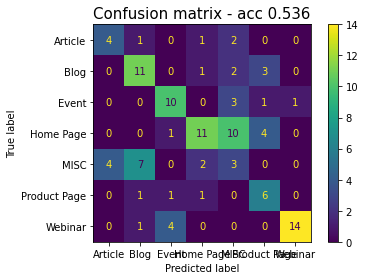

In [ ]:
# Class weight balanced
print_confusion_matrix(y_vals, y_preds, with_report=False)

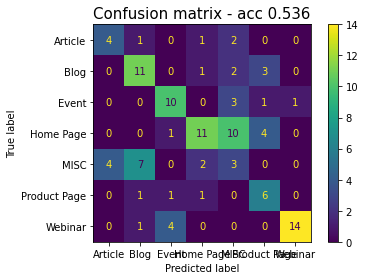

In [ ]:
print_confusion_matrix(y_vals, y_preds, with_report=False)

# 3. BERT approach (Ashwin N)

## Encoding labels

In [ ]:
! pwd

/content/drive/MyDrive/url_classification


In [ ]:
df_text.head(3)

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,2,NaN,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,5,NaN,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",5,NaN,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."


In [ ]:
df_text[['w2v_text', 'text', 'label']]

,w2v_text,text,label
0,2020 user summit . 2020 user summit * update...,2020 User Summit. 2020 User Summit *UPDATE - ...,2
1,write for us . want to write for us ? digita...,Write For Us. Want to Write for Us? Digital L...,5
2,"write for us . yes , you . we ’re always looki...","Write for Us. Yes, you. We’re always looking f...",5
3,faqs for some new features available in the be...,FAQs for some new features available in the Be...,1
4,the best nootropic stack to replace adderall &...,The Best Nootropic Stack to Replace Adderall &...,0
...,...,...,...
959,veeva systems korea aims to become cloud sw le...,Veeva Systems Korea aims to become cloud SW le...,0
960,digital transformation of clinical research ac...,Digital transformation of clinical research ac...,0
961,veeva systems is a top stock for 2022 . veeva ...,Veeva Systems is a Top Stock for 2022. Veeva S...,0
962,medidata ’s acorn ai solution raises clinical ...,Medidata’s Acorn AI solution raises clinical t...,0


In [ ]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

In [ ]:
df_text[TARGET].value_counts()

1    198
2    174
3    172
4    150
0     86
5     77
Name: label, dtype: int64

## Working with fixed validation data

### Preprocessing

In [43]:
df_text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,2,NaN,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,5,NaN,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",5,NaN,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,1,NaN,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,0,NaN,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...,...
959,Veeva Systems Korea aims to become cloud SW le...,0,http://www.koreabiomed.com/news/articleView.ht...,Veeva Systems Korea aims become cloud SW leade...,Veeva Systems Korea aim to become cloud SW lea...,Veeva Systems Korea aim become cloud SW leader...,veeva systems korea aims to become cloud sw le...
960,Digital transformation of clinical research ac...,0,http://www.outsourcing-pharma.com/Article/2021...,Digital transformation clinical research accel...,digital transformation of clinical research ac...,digital transformation clinical research accel...,digital transformation of clinical research ac...
961,Veeva Systems is a Top Stock for 2022. Veeva S...,0,http://www.entrepreneur.com/article/400416,Veeva Systems Top Stock 2022 Veeva Systems VEE...,Veeva Systems be a Top Stock for 2022 . Veeva ...,Veeva Systems Top Stock 2022 Veeva Systems VEE...,veeva systems is a top stock for 2022 . veeva ...
962,Medidata’s Acorn AI solution raises clinical t...,0,http://www.koreabiomed.com/news/articleView.ht...,Medidatas Acorn AI solution raises clinical tr...,Medidata ’s Acorn AI solution raise clinical t...,Medidata Acorn AI solution raise clinical tria...,medidata ’s acorn ai solution raises clinical ...


In [44]:
# df_positive = df_text[df_text[TARGET] != 5]
# df_negative = df_text[df_text[TARGET] == 5]

# Cell 9
test_size = 0.2
val_size = 0.1
random_state = 0

# Important cell # 9
column_used = 'text'

# X = df_positive[[column_used]]
# y = df_positive[TARGET]
X = df_text[[column_used]]
y = df_text[TARGET]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=1/((1-test_size)/val_size),
                                                    stratify=y_train_val, 
                                                    random_state=random_state)

# X_misc = df_negative[[column_used]]
# y_misc = df_negative[TARGET]
# X_test = pd.concat([X_test, X_misc])
# y_test = pd.concat([y_test, y_misc])

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((599, 1), (86, 1), (172, 1), (599,), (86,), (172,))

In [45]:
y_train.value_counts()

1    138
2    122
3    120
4    105
0     60
5     54
Name: label, dtype: int64

In [46]:
y_val.value_counts()

1    20
3    17
2    17
4    15
0     9
5     8
Name: label, dtype: int64

In [47]:
y_test.value_counts()

1    40
3    35
2    35
4    30
0    17
5    15
Name: label, dtype: int64

In [48]:
X_train

,text
103,5 Content Strategies for Boring Brands. “If pe...
486,Advancing digital-first delivery of care with ...
785,"Mayo Clinic, Verily to Build Advanced Clinical..."
343,SHRMNxTAPAC21 – SHRMI – Conferences. SHRM NxT ...
692,IQVIA Virtual Trial Solutions Used in More tha...
...,...
955,Top Cannabis VC Fund Poseidon Invests In Quali...
65,10 Helpful Tips for Choosing and Using Fonts. ...
168,"Write for us. Are you a digital marketer, want..."
436,Accenture and SHSMD. Healthcare organizations ...


In [49]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dataset = DatasetDict(
    {
    'train': Dataset.from_dict(
        {'text': X_train[column_used],
         'label': y_train,
         }
         ),
    'validation': Dataset.from_dict(
        {'text': X_val[column_used],
         'label': y_val,
         }
         ),
    'test': Dataset.from_dict(
        {'text': X_test[column_used],
         'label': y_test,
         }
         ),
    }
    )

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 599
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 86
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 172
    })
})

In [50]:
train_ds = dataset['train']

In [51]:
print(train_ds[:5])

{'text': ['5 Content Strategies for Boring Brands. “If people aren’t talking about you, they’re not talking about you for a reason. And the reason isn’t that they dislike you. They’re not talking about you because you’re boring.” ~ Seth Godin  The formidable challenge for marketers of boring brands is that you have to present content that is remarkable and interesting even when your product—on the face of it—is not.  So, how should you get people to take interest in a boring brand?  The key is in distinctive presentation. Every brand has a unique story about its origin, its people and its experience. The solution is to find an authentic theme, apply creative imagination and tell your story in a way that will attract and retain people’s attention. What was widely perceived to be boring could become inspiring or at least interesting to a group of people.  Let’s face it. Boring products solve legitimate problems too. QuickBooks, toilet paper and dentures fulfill a need just as much as, if

In [52]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
# model_ckpt = 'bert-base-uncased' # Node: 'tf_bert_for_sequence_classification/bert/encoder/layer_._8/intermediate/Gelu/mul_1' failed to allocate memory
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [53]:
text = "Tokenizing text is a core task of NLP 2021. See you on 31/12/2022."
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 25682, 1012, 2156, 2017, 2006, 2861, 1013, 2260, 1013, 16798, 2475, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [54]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '2021', '.', 'see', 'you', 'on', '31', '/', '12', '/', '202', '##2', '.', '[SEP]']


In [55]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp 2021. see you on 31 / 12 / 2022. [SEP]


In [56]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [57]:
print(tokenize(dataset["train"][:2])) 

{'input_ids': [[101, 1019, 4180, 9942, 2005, 11771, 9639, 1012, 1523, 2065, 2111, 4995, 1521, 1056, 3331, 2055, 2017, 1010, 2027, 1521, 2128, 2025, 3331, 2055, 2017, 2005, 1037, 3114, 1012, 1998, 1996, 3114, 3475, 1521, 1056, 2008, 2027, 18959, 2017, 1012, 2027, 1521, 2128, 2025, 3331, 2055, 2017, 2138, 2017, 1521, 2128, 11771, 1012, 1524, 1066, 6662, 2643, 2378, 1996, 18085, 4119, 2005, 3006, 2545, 1997, 11771, 9639, 2003, 2008, 2017, 2031, 2000, 2556, 4180, 2008, 2003, 9487, 1998, 5875, 2130, 2043, 2115, 4031, 1517, 2006, 1996, 2227, 1997, 2009, 1517, 2003, 2025, 1012, 2061, 1010, 2129, 2323, 2017, 2131, 2111, 2000, 2202, 3037, 1999, 1037, 11771, 4435, 1029, 1996, 3145, 2003, 1999, 8200, 8312, 1012, 2296, 4435, 2038, 1037, 4310, 2466, 2055, 2049, 4761, 1010, 2049, 2111, 1998, 2049, 3325, 1012, 1996, 5576, 2003, 2000, 2424, 2019, 14469, 4323, 1010, 6611, 5541, 9647, 1998, 2425, 2115, 2466, 1999, 1037, 2126, 2008, 2097, 9958, 1998, 9279, 2111, 1521, 1055, 3086, 1012, 2054, 2001, 4235, 

In [58]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [59]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 599
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 86
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 172
    })
})

In [60]:
from transformers import TFAutoModel 
tf_model = TFAutoModel.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [61]:
text = "this is a test"
inputs = tokenizer(text, return_tensors='tf')
inputs

{'input_ids': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[ 101, 2023, 2003, 1037, 3231,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [62]:
outputs = tf_model(inputs)
outputs

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 6, 768), dtype=float32, numpy=
array([[[-0.156513  , -0.18619666,  0.05277651, ..., -0.11881146,
          0.06620602,  0.5470156 ],
        [-0.3575139 , -0.6483559 , -0.0617902 , ..., -0.3040195 ,
          0.35076872,  0.5220684 ],
        [-0.27718496, -0.4459445 ,  0.1818425 , ..., -0.09477941,
         -0.00757464,  0.9958281 ],
        [-0.28408563, -0.3916768 ,  0.37525558, ..., -0.21505757,
         -0.11725189,  1.0526482 ],
        [ 0.2660821 , -0.509364  , -0.31801355, ..., -0.42029813,
          0.01444179, -0.21489467],
        [ 0.9440609 ,  0.01117263, -0.47139442, ...,  0.14394675,
         -0.7287836 , -0.16194907]]], dtype=float32)>, hidden_states=None, attentions=None)

In [63]:
outputs.last_hidden_state.shape

TensorShape([1, 6, 768])

In [64]:
dataset_encoded.reset_format()

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(
        batch["text"], 
        padding=True, 
        truncation=True, 
        return_tensors='tf',
        )
    # Extract last hidden states
    outputs = tf_model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

In [65]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=16)
dataset_hidden

  0%|          | 0/38 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 599
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 86
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 172
    })
})

In [66]:
import numpy as np
X_train_ = np.array(dataset_hidden["train"]["hidden_state"])
X_valid_ = np.array(dataset_hidden["validation"]["hidden_state"])
y_train_ = np.array(dataset_hidden["train"]["label"])
y_valid_ = np.array(dataset_hidden["validation"]["label"])
X_train_.shape, X_valid_.shape, y_train_.shape, y_valid_.shape

((599, 768), (86, 768), (599,), (86,))

In [67]:
X_test_ = np.array(dataset_hidden["test"]["hidden_state"])
y_test_ = np.array(dataset_hidden["test"]["label"])
X_test_.shape, y_test.shape

((172, 768), (172,))

In [68]:
X_train_

array([[-0.04961229,  0.0384727 , -0.07118477, ..., -0.1867758 ,
         0.39600113,  0.15715419],
       [-0.28209955, -0.09229711,  0.22186601, ..., -0.1048656 ,
         0.23100126,  0.26173201],
       [-0.41354528, -0.19282307, -0.10362765, ..., -0.11213232,
         0.46551567,  0.19092804],
       ...,
       [ 0.0584471 ,  0.02112034, -0.01251618, ..., -0.1512482 ,
         0.47226125,  0.2203968 ],
       [-0.13177465, -0.16667029, -0.00417405, ..., -0.24048589,
         0.31105435,  0.07123714],
       [-0.14194459, -0.03721767,  0.15154931, ..., -0.08806437,
         0.46088189,  0.52053249]])

In [69]:
X_train_valid_ = np.concatenate([X_train_, X_valid_])
X_train_.shape, X_valid_.shape, X_train_valid_.shape

((599, 768), (86, 768), (685, 768))

In [70]:
y_train_valid_ = np.concatenate([y_train_, y_valid_])
y_train_.shape, y_valid_.shape, y_train_valid_.shape

((599,), (86,), (685,))

In [71]:
# X_valid_test_ = np.concatenate([X_valid_, X_test_])
# X_valid_.shape, X_test_.shape, X_valid_test_.shape

In [72]:
# y_valid_test_ = np.concatenate([y_valid_, y_test_])
# y_valid_.shape, y_test_.shape, y_valid_test_.shape

### Modeling - machine learning approach:

In [73]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_valid_, y_train_valid_)
lr_clf.score(X_test_, y_test_)

0.8023255813953488

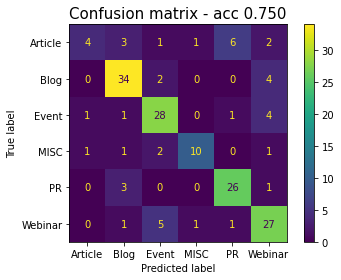


              precision    recall  f1-score   support

     Article       0.67      0.24      0.35        17
        Blog       0.79      0.85      0.82        40
       Event       0.74      0.80      0.77        35
        MISC       0.83      0.67      0.74        15
          PR       0.76      0.87      0.81        30
     Webinar       0.69      0.77      0.73        35

    accuracy                           0.75       172
   macro avg       0.75      0.70      0.70       172
weighted avg       0.75      0.75      0.74       172



In [74]:
rf_clf = fit_model(RandomForestClassifier(max_depth=10,
                                            n_estimators=50,
                                            random_state=0,
                                          ),
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(rf_clf, X_test_)
y_probs = rf_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

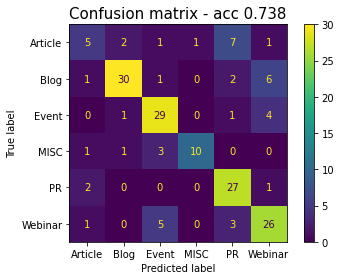


              precision    recall  f1-score   support

     Article       0.50      0.29      0.37        17
        Blog       0.88      0.75      0.81        40
       Event       0.74      0.83      0.78        35
        MISC       0.91      0.67      0.77        15
          PR       0.68      0.90      0.77        30
     Webinar       0.68      0.74      0.71        35

    accuracy                           0.74       172
   macro avg       0.73      0.70      0.70       172
weighted avg       0.74      0.74      0.73       172



In [76]:
svc_clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(svc_clf, X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

In [77]:
X_train_.shape

(599, 768)

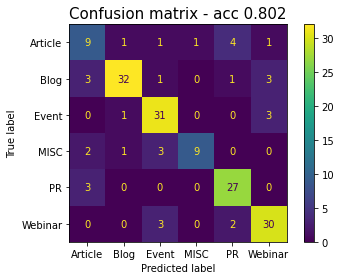


              precision    recall  f1-score   support

     Article       0.53      0.53      0.53        17
        Blog       0.91      0.80      0.85        40
       Event       0.79      0.89      0.84        35
        MISC       0.90      0.60      0.72        15
          PR       0.79      0.90      0.84        30
     Webinar       0.81      0.86      0.83        35

    accuracy                           0.80       172
   macro avg       0.79      0.76      0.77       172
weighted avg       0.81      0.80      0.80       172



In [78]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced', 
                                   ), 
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

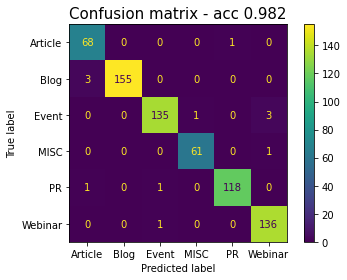


              precision    recall  f1-score   support

     Article       0.94      0.99      0.96        69
        Blog       1.00      0.98      0.99       158
       Event       0.99      0.97      0.98       139
        MISC       0.98      0.98      0.98        62
          PR       0.99      0.98      0.99       120
     Webinar       0.97      0.99      0.98       137

    accuracy                           0.98       685
   macro avg       0.98      0.98      0.98       685
weighted avg       0.98      0.98      0.98       685



In [79]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_valid_)
print_confusion_matrix(y_train_valid_, y_pred_train, with_report=True)

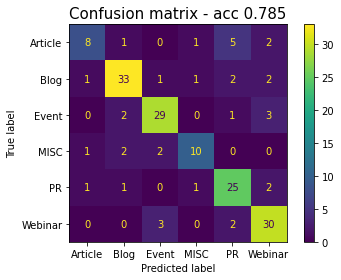


              precision    recall  f1-score   support

     Article       0.73      0.47      0.57        17
        Blog       0.85      0.82      0.84        40
       Event       0.83      0.83      0.83        35
        MISC       0.77      0.67      0.71        15
          PR       0.71      0.83      0.77        30
     Webinar       0.77      0.86      0.81        35

    accuracy                           0.78       172
   macro avg       0.78      0.75      0.75       172
weighted avg       0.79      0.78      0.78       172



In [80]:
lr_clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced',
    solver='liblinear', # default: 'lbfgs' 
    penalty='l1', # default: 'l2'
    ), 
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

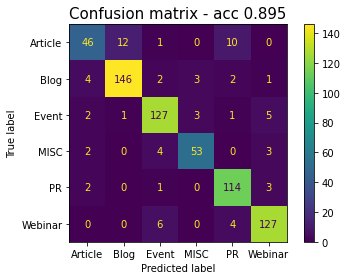


              precision    recall  f1-score   support

     Article       0.82      0.67      0.74        69
        Blog       0.92      0.92      0.92       158
       Event       0.90      0.91      0.91       139
        MISC       0.90      0.85      0.88        62
          PR       0.87      0.95      0.91       120
     Webinar       0.91      0.93      0.92       137

    accuracy                           0.89       685
   macro avg       0.89      0.87      0.88       685
weighted avg       0.89      0.89      0.89       685



In [81]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_valid_)
print_confusion_matrix(y_train_valid_, y_pred_train, with_report=True)

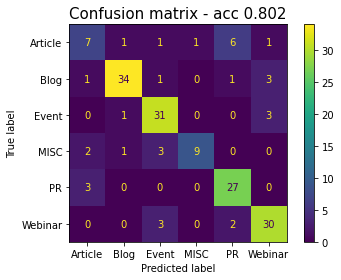


              precision    recall  f1-score   support

     Article       0.54      0.41      0.47        17
        Blog       0.92      0.85      0.88        40
       Event       0.79      0.89      0.84        35
        MISC       0.90      0.60      0.72        15
          PR       0.75      0.90      0.82        30
     Webinar       0.81      0.86      0.83        35

    accuracy                           0.80       172
   macro avg       0.79      0.75      0.76       172
weighted avg       0.80      0.80      0.80       172



In [82]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced', 
                                   ), 
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

In [83]:
# lr_clf = fit_model(LogisticRegression(
#     max_iter=3000, 
#     class_weight='balanced',
#     solver='saga', # default: 'lbfgs' 
#     penalty='elasticnet', # default: 'l2',
#     l1_ratio=0.9, # only relevant when penalty='elasticnet'
#     ), 
#                 X_train_, 
#                 y_train_)

# y_pred = predict(lr_clf, X_valid_test_)
# y_probs = lr_clf.predict_proba(X_valid_test_)

# print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

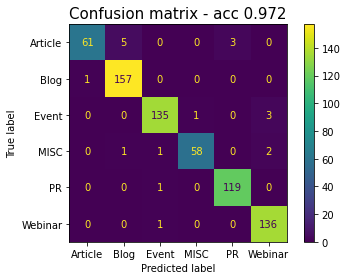


              precision    recall  f1-score   support

     Article       0.98      0.88      0.93        69
        Blog       0.96      0.99      0.98       158
       Event       0.98      0.97      0.97       139
        MISC       0.98      0.94      0.96        62
          PR       0.98      0.99      0.98       120
     Webinar       0.96      0.99      0.98       137

    accuracy                           0.97       685
   macro avg       0.97      0.96      0.97       685
weighted avg       0.97      0.97      0.97       685



In [84]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_valid_)
print_confusion_matrix(y_train_valid_, y_pred_train, with_report=True)

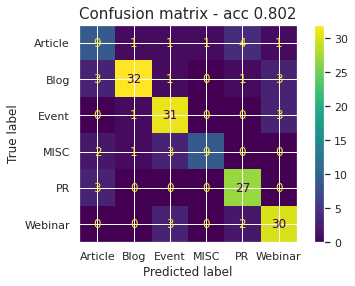


              precision    recall  f1-score   support

     Article       0.53      0.53      0.53        17
        Blog       0.91      0.80      0.85        40
       Event       0.79      0.89      0.84        35
        MISC       0.90      0.60      0.72        15
          PR       0.79      0.90      0.84        30
     Webinar       0.81      0.86      0.83        35

    accuracy                           0.80       172
   macro avg       0.79      0.76      0.77       172
weighted avg       0.81      0.80      0.80       172



In [175]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced', 
                                   ), 
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

In [157]:
pickle.dump(lr_clf, open('/content/drive/MyDrive/url_classification/Models/distilbert_lr_clf', 'wb'))

In [158]:
# lr_clf = pickle.load(open('/content/drive/MyDrive/url_classification/Models/distilbert_lr_clf', 'rb'))

In [86]:
df_text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,2,NaN,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,5,NaN,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",5,NaN,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,1,NaN,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,0,NaN,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...,...
959,Veeva Systems Korea aims to become cloud SW le...,0,http://www.koreabiomed.com/news/articleView.ht...,Veeva Systems Korea aims become cloud SW leade...,Veeva Systems Korea aim to become cloud SW lea...,Veeva Systems Korea aim become cloud SW leader...,veeva systems korea aims to become cloud sw le...
960,Digital transformation of clinical research ac...,0,http://www.outsourcing-pharma.com/Article/2021...,Digital transformation clinical research accel...,digital transformation of clinical research ac...,digital transformation clinical research accel...,digital transformation of clinical research ac...
961,Veeva Systems is a Top Stock for 2022. Veeva S...,0,http://www.entrepreneur.com/article/400416,Veeva Systems Top Stock 2022 Veeva Systems VEE...,Veeva Systems be a Top Stock for 2022 . Veeva ...,Veeva Systems Top Stock 2022 Veeva Systems VEE...,veeva systems is a top stock for 2022 . veeva ...
962,Medidata’s Acorn AI solution raises clinical t...,0,http://www.koreabiomed.com/news/articleView.ht...,Medidatas Acorn AI solution raises clinical tr...,Medidata ’s Acorn AI solution raise clinical t...,Medidata Acorn AI solution raise clinical tria...,medidata ’s acorn ai solution raises clinical ...


In [87]:
labels_encoded

{'Article': 0, 'Blog': 1, 'Event': 2, 'Webinar': 3, 'PR': 4, 'MISC': 5}

In [93]:
mask = y_pred != y_test_

In [113]:
X_test = pd.DataFrame(X_test, columns=['text']) # transform into DataFrame

misclassified_df = create_misclassified_df(X_test=X_test, y_test=y_test, y_pred=y_pred)
assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
misclassified_df.head()

,text,y_true,y_pred
932,"IQVIA (IQV) Buys Remaining Q2 Solutions Stake,...",PR,Article
713,CVS inks a deal with Medable to enroll more pa...,Article,Webinar
680,California ends Verily COVID-19 testing partne...,Article,PR
84,"How to Use Hashtags: How Many, Best Ones, and ...",Blog,Article
791,Overview of EMA's latest IDMP Updates in 2022....,Blog,Webinar


In [ ]:
# X_valid_test = np.concatenate([X_val, X_test]) # concatenate
# X_valid_test = pd.DataFrame(X_valid_test, columns=['text']) # transform into DataFrame

# misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_valid_test_, y_pred=y_pred)
# assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
# misclassified_df

In [121]:
misclassified_df.shape

(34, 3)

In [122]:
df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
df_merged.index = misclassified_df.index
df_merged

,text,y_true,y_pred,url
932,"IQVIA (IQV) Buys Remaining Q2 Solutions Stake,...",PR,Article,http://www.zacks.com/stock/news/1348735/iqvia-...
713,CVS inks a deal with Medable to enroll more pa...,Article,Webinar,http://www.statnews.com/2022/02/08/cvs-medable...
680,California ends Verily COVID-19 testing partne...,Article,PR,http://www.beckershospitalreview.com/healthcar...
84,"How to Use Hashtags: How Many, Best Ones, and ...",Blog,Article,NaN
791,Overview of EMA's latest IDMP Updates in 2022....,Blog,Webinar,http://www.calyx.ai/journal/overview-ema-lates...
880,The Power of Patient-Centricity in Rare Diseas...,Blog,Webinar,http://medrio.com/resource/the-power-of-patien...
904,Introducing a Medical Perspective on Clinical ...,Blog,PR,http://www.calyx.ai/journal/a-medical-perspect...
524,New Data on the Future of CNS Clinical Trials....,Webinar,Event,http://science37.com/Company/Events/webinar-ne...
207,What Do Millennials Really Want at Work? The S...,Article,MISC,NaN
222,Fully Managed Magento Hosting — JetRails. Full...,MISC,Event,NaN


In [123]:
df_merged.shape

(34, 4)

In [124]:
df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
df_confidences.head()

,y_true,y_pred
932,4,0
713,0,3
680,0,4
84,1,0
791,1,3


In [125]:
df_confidences.shape

(34, 2)

In [129]:
mask = y_pred != y_test

In [130]:
# mask = y_pred != y_valid_test_ and y_valid_test_ != 5

In [131]:
y_probs[mask][:3]

array([[4.78920389e-01, 2.02651315e-01, 9.93016026e-02, 2.53982528e-02,
        1.05969636e-02, 1.83131478e-01],
       [4.54252856e-03, 9.52887533e-04, 1.32076621e-02, 6.58280716e-01,
        3.38966395e-04, 3.22677239e-01],
       [2.24608589e-01, 3.76523970e-03, 1.80739765e-03, 1.77883163e-03,
        7.60422420e-01, 7.61752234e-03]])

In [132]:
df_confidences['y_true']

932    4
713    0
680    0
84     1
791    1
880    1
904    1
524    3
207    0
222    5
619    3
951    4
842    1
371    2
338    2
921    0
822    1
309    2
329    5
778    0
626    5
102    0
741    4
228    3
112    5
960    0
39     5
555    3
456    3
61     1
3      1
206    0
121    5
299    2
Name: y_true, dtype: int64

In [133]:
# num_misc = (df_confidences['y_true'] == 5).sum()
# num_misc

In [134]:
confidence_pred = y_probs[mask, df_confidences['y_pred']]
confidence_pred

array([0.47892039, 0.65828072, 0.76042242, 0.52470149, 0.5756369 ,
       0.45995986, 0.44297741, 0.52138024, 0.83890112, 0.35701317,
       0.53240462, 0.44389242, 0.74164669, 0.74827989, 0.75120292,
       0.58843639, 0.94519173, 0.576738  , 0.63902982, 0.45591526,
       0.74999727, 0.815721  , 0.61629456, 0.80713943, 0.6981093 ,
       0.47132147, 0.45950802, 0.48912313, 0.65825767, 0.58431903,
       0.55716535, 0.64218227, 0.72546744, 0.52253999])

In [135]:
confidence_true = y_probs[mask, df_confidences['y_true']]
confidence_true

array([1.05969636e-02, 4.54252856e-03, 2.24608589e-01, 2.14161798e-01,
       3.96017927e-02, 3.43550453e-01, 1.45051089e-01, 3.27122609e-01,
       8.46974483e-03, 2.97857886e-01, 2.65377519e-01, 2.18466589e-02,
       2.53384377e-03, 1.50185148e-01, 1.87167211e-01, 4.07500013e-01,
       3.71312290e-02, 4.56519034e-02, 3.71999079e-02, 4.54945043e-01,
       5.91594853e-02, 1.79028439e-01, 2.28620920e-01, 1.09064000e-01,
       2.79600473e-01, 1.49645210e-01, 3.55256957e-01, 1.67529614e-01,
       1.83067657e-01, 3.95572507e-01, 4.18580840e-01, 2.07965878e-04,
       2.51050828e-01, 3.69727077e-01])

In [136]:
# confidence_true = y_probs[:-num_misc][mask[:-num_misc], df_confidences['y_true'][:-num_misc]]
# confidence_true = np.concatenate((confidence_true, np.zeros(num_misc)), axis=0)
# confidence_true

In [137]:
df_merged['conf_true'] = confidence_true.round(2)
df_merged['conf_pred'] = confidence_pred.round(2)

In [138]:
df_merged.tail()

,text,y_true,y_pred,url,conf_true,conf_pred
61,Artificial Intelligence Is Here - People Just ...,Blog,Article,NaN,0.40,0.58
3,FAQs for some new features available in the Be...,Blog,Article,NaN,0.42,0.56
206,How to Do Walking Meetings Right. New! HBR Le...,Article,Event,NaN,0.00,0.64
121,font-display | CSS-Tricks. The font-display pr...,MISC,Article,NaN,0.25,0.73
299,In Conduct of Decentralized Trials. In today’s...,Event,Webinar,http://app.swapcard.com/event/scdm-2021-annual...,0.37,0.52


In [139]:
df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]

In [140]:
df_merged.shape

(34, 6)

In [171]:
df = df_merged.iloc[13:, :]

In [172]:
df.drop('text', axis=1).head(3)

,url,y_true,conf_true,y_pred,conf_pred
371,http://www.eventbrite.com/e/women-leaders-in-e...,Event,0.15,Webinar,0.75
338,http://dgevents.com/event/4th-virtual-clinical...,Event,0.19,Webinar,0.75
921,http://www.wraltechwire.com/2021/10/08/iqvia-a...,Article,0.41,PR,0.59


In [142]:
save_variable(df_merged, 'df_merged')

In [143]:
misclassified_urls = df_merged['url'].tolist()
misclassified_urls

['http://www.zacks.com/stock/news/1348735/iqvia-iqv-buys-remaining-q2-solutions-stake-ups-eps-view?cid=CS-ZC-FT-analyst_blog%7Ccompany_news_-_corporate_actions-1348735',
 'http://www.statnews.com/2022/02/08/cvs-medable-clinical-trials/',
 'http://www.beckershospitalreview.com/healthcare-information-technology/california-ends-verily-covid-19-testing-partnership.html',
 nan,
 'http://www.calyx.ai/journal/overview-ema-latest-idmp-updates/',
 'http://medrio.com/resource/the-power-of-patient-centricity-in-rare-disease-studies/',
 'http://www.calyx.ai/journal/a-medical-perspective-on-clinical-trial-technology/',
 'http://science37.com/Company/Events/webinar-new-data-future-cns-clinical-trials',
 nan,
 nan,
 'http://pages.questexinfo.com/glookowbnr12082021/?pk=Glooko',
 'http://www.zacks.com/stock/news/1754370/iqvia-iqv-announces-launch-of-clinical-data-analytics-suite?cid=CS-ZC-FT-analyst_blog%7Ccompany_news_-_corporate_actions-1754370',
 'http://www.calyx.ai/journal/ctms-unlocking-clinical-

In [144]:
wrong_conf_pred = np.max(y_probs[mask], axis=1)
wrong_conf_pred[:3]

array([0.47892039, 0.65828072, 0.76042242])

In [145]:
right_conf_pred = np.max(y_probs[~mask], axis=1)
right_conf_pred[:3]

array([0.91778454, 0.5124954 , 0.98625083])

In [146]:
assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

In [149]:
# Comparison between using 'l1' vs 'l2' regularization (without class Article, with Home Page):
# Acc test set - 'l1': 0.812, 'l2': 0.808
# Acc train set - 'l1': 0.898, 'l2': 0.983
# Average confidence of misclassified samples - 'l1': 0.5134, 'l2': 0.6213
# Average confidence of correctly classified samples - 'l1': 0.6977, 'l2': 0.8412
# Median confidence of misclassified samples - 'l1': 0.4976, 'l2': 0.5665
# Median confidence of correctly classified samples - 'l1': 0.7224, 'l2': 0.8995

In [150]:
# Comparison between using 'l1' vs 'l2' regularization (with class Article, without Home Page):
# Acc test set - 'l1': 0.717, 'l2': 0.759
# Acc train set - 'l1': 0.886, 'l2': 0.988
# Average confidence of misclassified samples - 'l1': 0.581, 'l2': 0.600
# Average confidence of correctly classified samples - 'l1': 0.671, 'l2': 0.660
# Median confidence of misclassified samples - 'l1': 0.564, 'l2': 0.5813
# Median confidence of correctly classified samples - 'l1': 0.698, 'l2': 0.6841

In [176]:
sns.set_theme()

In [177]:
print(f'Confidence of incorrectly classified samples \t- Median: {np.median(wrong_conf_pred):.4f}, Mean: {np.mean(wrong_conf_pred):.4f}.')
print(f'Confidence of correctly classified samples \t- Median: {np.median(right_conf_pred):.4f}, Mean: {np.mean(right_conf_pred):.4f}.')

Confidence of incorrectly classified samples 	- Median: 0.5864, Mean: 0.6129.
Confidence of correctly classified samples 	- Median: 0.8799, Mean: 0.8284.


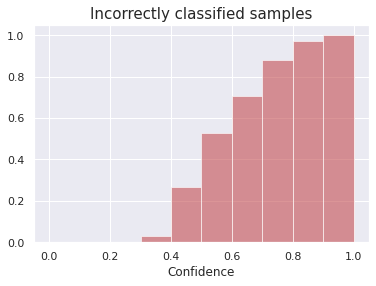

In [178]:
density=True
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6)
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6, cumulative=1)
# plt.title('Cumulative confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

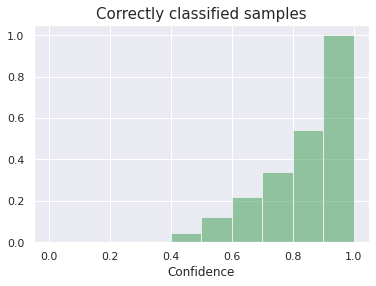

In [179]:
density=True
# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='b', alpha=0.6)
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='g', alpha=0.6, cumulative=1)
# plt.title('Cumulative confidence distribution in correctly classified samples\n', size=14)
plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

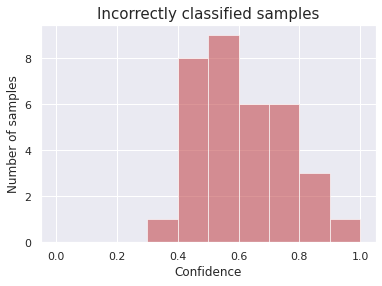

In [180]:
density=False
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='r')
# plt.title('Confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

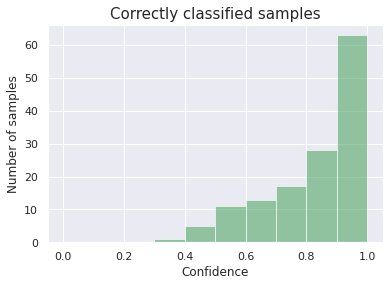

In [181]:
density=False
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='g')
# plt.title('Confidence distribution in correctly classified samples\n', size=14)
plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

In [155]:
# misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_valid_test_, y_pred=y_pred)
# assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
# # misclassified_df

# df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
# df_merged.index = misclassified_df.index
# # df_merged

# df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
# # df_confidences.head()

# mask = y_pred != y_valid_test_

# confidence_pred = y_probs[mask, df_confidences['y_pred']]
# # confidence_pred

# confidence_true = y_probs[mask, df_confidences['y_true']]
# # confidence_true

# df_merged['conf_true'] = confidence_true.round(2)
# df_merged['conf_pred'] = confidence_pred.round(2)
# # df_merged.head()

# df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]
# # df_merged.head()

# save_variable(df_merged, 'df_merged_nn')

# misclassified_urls = df_merged['url'].tolist()
# # misclassified_urls

# wrong_conf_pred = np.max(y_probs[mask], axis=1)
# # wrong_conf_pred[:3]

# right_conf_pred = np.max(y_probs[~mask], axis=1)
# # right_conf_pred[:3]

# assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

# print(f'Average confidence of misclassified samples: {np.mean(wrong_conf_pred):.4f}')
# print(f'Average confidence of correctly classified samples: {np.mean(right_conf_pred):.4f}')

# print(f'Median confidence of misclassified samples: {np.median(wrong_conf_pred):.4f}')
# print(f'Median confidence of correctly classified samples: {np.median(right_conf_pred):.4f}')

# density=None
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in misclassified samples')
# plt.show()

# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in correctly classified samples')
# plt.show()

### Modeling - deep learning approach v1:

In [182]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [183]:
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [184]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [185]:
# The column names to convert to TensorFlow tensors
# from transformers import DataCollatorForTokenClassification
# from transformers import DefaultDataCollator
from transformers import DataCollatorWithPadding

tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 16

# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DefaultDataCollator(return_tensors="tf")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = dataset_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, 
    label_cols=["label"], 
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
    )

tf_eval_dataset = dataset_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, 
    label_cols=["label"], 
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
    )

tf_train_dataset

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [186]:
tf_test_dataset = dataset_encoded["test"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["label"], 
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
    )

In [187]:
num_labels = len(y_train.value_counts())

In [188]:
from transformers import TFDistilBertModel, DistilBertConfig

DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.1
 
# Configure DistilBERT's initialization
config = DistilBertConfig(
    dropout=DISTILBERT_DROPOUT, 
    attention_dropout=DISTILBERT_ATT_DROPOUT,
    output_hidden_states=True,
    num_labels=num_labels,
    )
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
# tf_model = TFDistilBertModel.from_pretrained(
#     'distilbert-base-uncased', 
#     config=config
#     )

# # # Make tf_model layers untrainable
# for layer in tf_model.layers:
#     layer.trainable = False

In [189]:
from transformers import TFAutoModelForSequenceClassification
tf_model = (TFAutoModelForSequenceClassification.from_pretrained(
    model_ckpt, 
    config=config, 
    # num_labels=num_labels,
    )
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_38', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [190]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# With:
# DISTILBERT_DROPOUT = 0.1
# DISTILBERT_ATT_DROPOUT = 0.1

epochs = 1000
patience = 5

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
    )

callback = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
    )

history = tf_model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset, 
    epochs=epochs,
    callbacks=[callback]
    )

Epoch 1/1000
38/38 [==============================] - 48s 1s/step - loss: 1.7609 - sparse_categorical_accuracy: 0.2521 - val_loss: 1.6946 - val_sparse_categorical_accuracy: 0.4767
Epoch 2/1000
38/38 [==============================] - 37s 979ms/step - loss: 1.6179 - sparse_categorical_accuracy: 0.5893 - val_loss: 1.5302 - val_sparse_categorical_accuracy: 0.7093
Epoch 3/1000
38/38 [==============================] - 37s 980ms/step - loss: 1.4147 - sparse_categorical_accuracy: 0.6878 - val_loss: 1.3233 - val_sparse_categorical_accuracy: 0.6977
Epoch 4/1000
38/38 [==============================] - 37s 987ms/step - loss: 1.2047 - sparse_categorical_accuracy: 0.7078 - val_loss: 1.1303 - val_sparse_categorical_accuracy: 0.7093
Epoch 5/1000
38/38 [==============================] - 37s 982ms/step - loss: 1.0323 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.9867 - val_sparse_categorical_accuracy: 0.7209
Epoch 6/1000
38/38 [==============================] - 38s 988ms/step - loss: 0.8964 - sp

In [175]:
# tf.keras.models.save_model(
#     tf_model, 
#     filepath='/content/drive/MyDrive/url_classification/my_model_val0.84_test0.89', 
#     overwrite=True, 
#     save_format='tf'
#     )

In [ ]:
tf_model.save('/content/drive/MyDrive/Brew/my_model_val0.87_test0.8')

In [ ]:
# ! pwd

/content/drive/.shortcut-targets-by-id/1vLy-uUgLo6ivB3DawGntodciS6HG1L58/url_classification


In [176]:
# tf.saved_model.save(tf_model, '/content/drive/MyDrive/Brew/my_model_delete')

In [ ]:
from tensorflow.keras.models import load_model
tf_model2 = load_model(filepath='/content/drive/MyDrive/Brew/my_model_delete') 

In [ ]:
tf_model2 = tf.saved_model.load('/content/drive/MyDrive/Brew/my_model_delete')

In [188]:
tf.keras.models.save_model(tf_model, '/content/drive/MyDrive/url_classification/my_model_val0.81_test0.85')

In [ ]:
tf_model

In [186]:
tf_model2 = tf.keras.models.load_model(filepath='/content/drive/MyDrive/url_classification/my_model_val0.84_test0.89') 
# # why doesn't it work when running the next cell with the loaded model?

OSError: ignored

In [ ]:
custom_objects = {"TFAutoModelForSequenceClassification": TFAutoModelForSequenceClassification}

tf_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Brew/my_model_delete', custom_objects=custom_objects)

In [178]:
# loss, train_accuracy = tf_model2.evaluate(tf_train_dataset)
# print("Loss: {}\t Train Accuracy: {}".format(loss, train_accuracy))

In [191]:
loss, train_accuracy = tf_model.evaluate(tf_train_dataset)
print("Loss: {}\t Train Accuracy: {}".format(loss, train_accuracy))

38/38 [==============================] - 12s 316ms/step - loss: 0.1531 - sparse_categorical_accuracy: 0.9750
Loss: 0.15307635068893433	 Train Accuracy: 0.9749582409858704


In [192]:
loss, eval_accuracy = tf_model.evaluate(tf_eval_dataset)
print("Loss: {}\t Eval Accuracy: {}".format(loss, eval_accuracy))

6/6 [==============================] - 2s 285ms/step - loss: 0.6126 - sparse_categorical_accuracy: 0.8256
Loss: 0.6125950813293457	 Eval Accuracy: 0.8255813717842102


In [193]:
loss, test_accuracy = tf_model.evaluate(tf_test_dataset)
print("Loss: {}\t Test Accuracy: {}".format(loss, test_accuracy))

11/11 [==============================] - 4s 325ms/step - loss: 0.5771 - sparse_categorical_accuracy: 0.8372
Loss: 0.5770680904388428	 Test Accuracy: 0.8372092843055725


In [194]:
output_logits = tf_model.predict(tf_test_dataset).logits
y_pred = np.argmax(output_logits, axis=-1)

11/11 [==============================] - 5s 321ms/step


In [195]:
y_pred

array([1, 0, 1, 1, 3, 5, 4, 4, 2, 4, 1, 3, 1, 0, 3, 3, 4, 3, 2, 2, 3, 4,
       4, 5, 2, 2, 5, 3, 3, 4, 1, 2, 5, 2, 1, 1, 1, 1, 0, 1, 4, 3, 3, 2,
       1, 1, 3, 4, 3, 2, 3, 1, 4, 3, 1, 4, 3, 4, 2, 3, 5, 0, 2, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 2, 4, 1, 1, 4, 0, 1,
       1, 4, 5, 2, 1, 1, 4, 1, 4, 4, 3, 3, 2, 5, 0, 3, 5, 4, 1, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 4, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 1, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 3, 0,
       0, 4, 3, 3, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [196]:
y_probs = tf.nn.softmax(output_logits)
y_probs[:3]

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0.08416542, 0.878566  , 0.00733409, 0.01031895, 0.00701632,
        0.01259932],
       [0.7317688 , 0.05313385, 0.0171092 , 0.01492369, 0.12416278,
        0.05890167],
       [0.08567395, 0.85064834, 0.01047275, 0.03116656, 0.0085467 ,
        0.01349174]], dtype=float32)>

In [199]:
sns.set_theme(style='white')

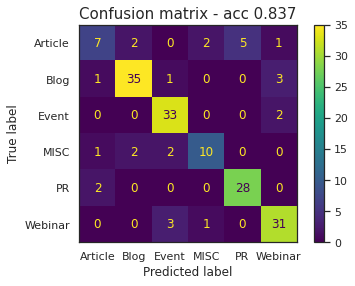


              precision    recall  f1-score   support

     Article       0.64      0.41      0.50        17
        Blog       0.90      0.88      0.89        40
       Event       0.85      0.94      0.89        35
        MISC       0.77      0.67      0.71        15
          PR       0.85      0.93      0.89        30
     Webinar       0.84      0.89      0.86        35

    accuracy                           0.84       172
   macro avg       0.81      0.79      0.79       172
weighted avg       0.83      0.84      0.83       172



In [200]:
print_confusion_matrix(y_test, y_pred, with_report=True)

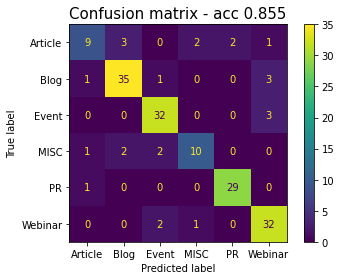


              precision    recall  f1-score   support

     Article       0.75      0.53      0.62        17
        Blog       0.88      0.88      0.88        40
       Event       0.86      0.91      0.89        35
        MISC       0.77      0.67      0.71        15
          PR       0.94      0.97      0.95        30
     Webinar       0.82      0.91      0.86        35

    accuracy                           0.85       172
   macro avg       0.84      0.81      0.82       172
weighted avg       0.85      0.85      0.85       172



In [185]:
print_confusion_matrix(y_test, y_pred, with_report=True)

In [201]:
y_pred

array([1, 0, 1, 1, 3, 5, 4, 4, 2, 4, 1, 3, 1, 0, 3, 3, 4, 3, 2, 2, 3, 4,
       4, 5, 2, 2, 5, 3, 3, 4, 1, 2, 5, 2, 1, 1, 1, 1, 0, 1, 4, 3, 3, 2,
       1, 1, 3, 4, 3, 2, 3, 1, 4, 3, 1, 4, 3, 4, 2, 3, 5, 0, 2, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 2, 4, 1, 1, 4, 0, 1,
       1, 4, 5, 2, 1, 1, 4, 1, 4, 4, 3, 3, 2, 5, 0, 3, 5, 4, 1, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 4, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 1, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 3, 0,
       0, 4, 3, 3, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [202]:
y_test

831    1
932    4
821    1
843    1
642    3
      ..
404    2
405    2
563    3
909    1
580    3
Name: label, Length: 172, dtype: int64

In [203]:
mask = y_pred != y_test
mask

831    False
932     True
821    False
843    False
642    False
       ...  
404    False
405    False
563    False
909    False
580    False
Name: label, Length: 172, dtype: bool

In [204]:
y_pred

array([1, 0, 1, 1, 3, 5, 4, 4, 2, 4, 1, 3, 1, 0, 3, 3, 4, 3, 2, 2, 3, 4,
       4, 5, 2, 2, 5, 3, 3, 4, 1, 2, 5, 2, 1, 1, 1, 1, 0, 1, 4, 3, 3, 2,
       1, 1, 3, 4, 3, 2, 3, 1, 4, 3, 1, 4, 3, 4, 2, 3, 5, 0, 2, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 2, 4, 1, 1, 4, 0, 1,
       1, 4, 5, 2, 1, 1, 4, 1, 4, 4, 3, 3, 2, 5, 0, 3, 5, 4, 1, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 4, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 1, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 3, 0,
       0, 4, 3, 3, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [205]:
np.array(y_test)

array([1, 4, 1, 1, 3, 0, 0, 4, 2, 4, 1, 1, 1, 0, 3, 1, 4, 3, 3, 2, 3, 4,
       4, 0, 2, 2, 5, 3, 3, 4, 1, 3, 5, 2, 1, 1, 1, 1, 4, 1, 4, 1, 3, 2,
       1, 0, 2, 0, 3, 2, 3, 1, 0, 3, 1, 4, 3, 4, 2, 3, 5, 0, 1, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 5, 0, 1, 1, 4, 0, 1,
       1, 4, 3, 5, 1, 0, 4, 1, 4, 4, 3, 3, 3, 5, 1, 3, 5, 4, 5, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 0, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 5, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 0, 0,
       5, 4, 3, 2, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [206]:
len(y_test), len(y_pred)

(172, 172)

In [207]:
misclassified_df_nn = pd.DataFrame(
    {'y_true': y_test[mask].reset_index(drop=True).replace(labels_decoded),
     'y_pred': pd.Series(y_pred[mask]).replace(labels_decoded),
     }).set_index(y_test[mask].index)
misclassified_df_nn

,y_true,y_pred
932,PR,Article
713,Article,MISC
680,Article,PR
791,Blog,Webinar
904,Blog,Webinar
524,Webinar,Event
207,Article,MISC
538,Webinar,Event
951,PR,Article
842,Blog,Webinar


In [208]:
# I can merge with url/text using the index of y_test, do it later.

In [209]:
df_confidences_nn = misclassified_df_nn[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
df_confidences_nn.head()

,y_true,y_pred
932,4,0
713,0,5
680,0,4
791,1,3
904,1,3


In [210]:
y_probs_array = np.array(y_probs)

In [211]:
confidence_pred_nn = y_probs_array[mask, df_confidences_nn['y_pred']]
confidence_pred_nn

array([0.7317688 , 0.6880048 , 0.87609005, 0.8604847 , 0.9083877 ,
       0.6410547 , 0.81165284, 0.9317813 , 0.47587645, 0.9376277 ,
       0.61182654, 0.84027946, 0.8377481 , 0.8389856 , 0.851417  ,
       0.9430426 , 0.9203028 , 0.54665744, 0.9204443 , 0.8084895 ,
       0.9474942 , 0.32922313, 0.8855198 , 0.694019  , 0.7159665 ,
       0.85666305, 0.73370403, 0.9439738 ], dtype=float32)

In [212]:
confidence_true_nn = y_probs_array[mask, df_confidences_nn['y_true']]
confidence_true_nn

array([0.12416278, 0.06829616, 0.0711691 , 0.02685313, 0.02636965,
       0.26135868, 0.0567484 , 0.02559043, 0.4171192 , 0.01154234,
       0.32100692, 0.04748523, 0.11640108, 0.10977008, 0.0378789 ,
       0.01535015, 0.04170987, 0.31138265, 0.02573165, 0.14057119,
       0.0131673 , 0.25806272, 0.01883534, 0.22927858, 0.06642533,
       0.00938151, 0.05739936, 0.0123579 ], dtype=float32)

In [213]:
misclassified_df_nn['conf_true'] = confidence_true_nn.round(2)
misclassified_df_nn['conf_pred'] = confidence_pred_nn.round(2)
misclassified_df_nn.head()

,y_true,y_pred,conf_true,conf_pred
932,PR,Article,0.12,0.73
713,Article,MISC,0.07,0.69
680,Article,PR,0.07,0.88
791,Blog,Webinar,0.03,0.86
904,Blog,Webinar,0.03,0.91


In [214]:
misclassified_df_nn = misclassified_df_nn[['y_true', 'conf_true', 'y_pred', 'conf_pred']]
misclassified_df_nn

,y_true,conf_true,y_pred,conf_pred
932,PR,0.12,Article,0.73
713,Article,0.07,MISC,0.69
680,Article,0.07,PR,0.88
791,Blog,0.03,Webinar,0.86
904,Blog,0.03,Webinar,0.91
524,Webinar,0.26,Event,0.64
207,Article,0.06,MISC,0.81
538,Webinar,0.03,Event,0.93
951,PR,0.42,Article,0.48
842,Blog,0.01,Webinar,0.94


In [203]:
save_variable(misclassified_df_nn, 'df_merged_nn')

In [215]:
wrong_conf_pred = np.max(y_probs_array[mask], axis=1)
wrong_conf_pred[:3]

array([0.7317688 , 0.6880048 , 0.87609005], dtype=float32)

In [216]:
right_conf_pred = np.max(y_probs_array[~mask], axis=1)
right_conf_pred[:3]

array([0.878566  , 0.85064834, 0.9120738 ], dtype=float32)

In [217]:
assert y_probs_array.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

In [291]:
print(f'Confidence of incorrectly classified samples \t- Median: {np.median(wrong_conf_pred):.4f}, Mean: {np.mean(wrong_conf_pred):.4f}.')
print(f'Confidence of correctly classified samples \t- Median: {np.median(right_conf_pred):.4f}, Mean: {np.mean(right_conf_pred):.4f}.')

Confidence of incorrectly classified samples 	- Median: 0.8021, Mean: 0.7702.
Confidence of correctly classified samples 	- Median: 0.9231, Mean: 0.8750.


In [259]:
sns.set_theme()

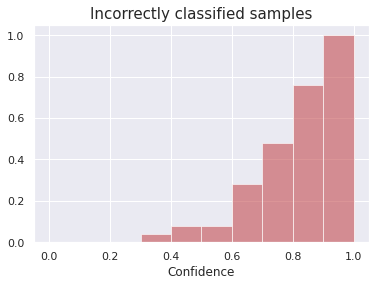

In [310]:
density=True
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6)
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6, cumulative=1)
# plt.title('Cumulative confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

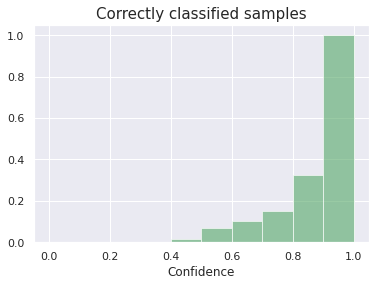

In [311]:
density=True
# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='b', alpha=0.6)
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='g', alpha=0.6, cumulative=1)
# plt.title('Cumulative confidence distribution in correctly classified samples\n', size=14)
plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

In [241]:
total_count = len(wrong_conf_pred)
weights = [1 / total_count for x in wrong_conf_pred]

In [244]:
weights = 0.04

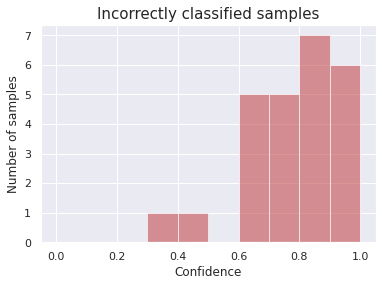

In [303]:
density=False
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='r')
# plt.title('Confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

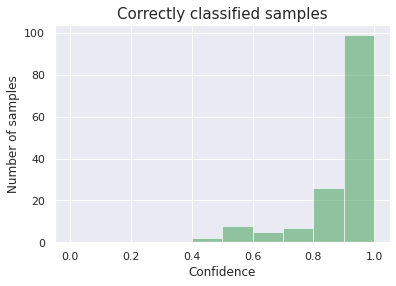

In [304]:
density=False
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='g')
# plt.title('Confidence distribution in correctly classified samples\n', size=14)
plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

In [ ]:
# misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_test, y_pred=y_pred)
# assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
# misclassified_df

# df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
# df_merged.index = misclassified_df.index
# # df_merged

# df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
# # df_confidences.head()

# mask = y_pred != y_valid_test_

# confidence_pred = y_probs[mask, df_confidences['y_pred']]
# # confidence_pred

# confidence_true = y_probs[mask, df_confidences['y_true']]
# # confidence_true

# df_merged['conf_true'] = confidence_true.round(2)
# df_merged['conf_pred'] = confidence_pred.round(2)
# # df_merged.head()

# df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]
# # df_merged.head()

# save_variable(df_merged, 'df_merged_nn')

# misclassified_urls = df_merged['url'].tolist()
# # misclassified_urls

# wrong_conf_pred = np.max(y_probs[mask], axis=1)
# # wrong_conf_pred[:3]

# right_conf_pred = np.max(y_probs[~mask], axis=1)
# # right_conf_pred[:3]

# assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

# print(f'Average confidence of misclassified samples: {np.mean(wrong_conf_pred):.4f}')
# print(f'Average confidence of correctly classified samples: {np.mean(right_conf_pred):.4f}')

# print(f'Median confidence of misclassified samples: {np.median(wrong_conf_pred):.4f}')
# print(f'Median confidence of correctly classified samples: {np.median(right_conf_pred):.4f}')

# density=None
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in misclassified samples')
# plt.show()

# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in correctly classified samples')
# plt.show()

### Modeling - deep learning approach v2:

In [ ]:
# Cell 9
test_size = 0.15
random_state = 0

# Important cell # 9
column_used = 'w2v_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=1/((1-test_size)/test_size),
                                                    stratify=y_train_val, 
                                                    random_state=random_state)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((483, 1), (104, 1), (104, 1), (483,), (104,), (104,))

In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dataset = DatasetDict({
    'train': Dataset.from_dict({'text': X_train[column_used],'label': y_train}),
    'validation': Dataset.from_dict({'text': X_val[column_used],'label': y_val}),
    'test': Dataset.from_dict({'text': X_test[column_used],'label': y_test})
    })

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 483
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 104
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 104
    })
})

In [ ]:
tokenizer2 = AutoTokenizer.from_pretrained('distilgpt2')

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenizer2.pad_token = tokenizer2.eos_token

In [ ]:
tokenizer2

PreTrainedTokenizerFast(name_or_path='distilgpt2', vocab_size=50257, model_max_len=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'})

In [ ]:
tokenizer2.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>'}

In [ ]:
transformers.__version__

'4.25.1'

In [ ]:
datasets.__version__

'2.7.1'

In [ ]:
# ds = datasets.Dataset.from_pandas(df_text)

In [ ]:
# ds

Dataset({
    features: ['text', 'label', 'url', 'cleaned_text', 'lemmatized_text', 'lemmatized_cleaned_text', 'w2v_text'],
    num_rows: 691
})

In [ ]:
# ds[0]

{'text': "2020 User Summit. 2020 User Summit  *UPDATE - March 12th, 2020*  With the ongoing coverage of the seriousness of the global outbreak of the COVID-19 virus and the potential effects, we want you to know that our priority is to keep our Summit attendees safe and informed.  While our AC User Summit is just more than a month away, we are sensitive to our clients' travel and safety. Out of an abundance of caution and concern, we have decided to cancel the 2020 User Summit in the best interest of all involved.  While we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.  Registration fees will be credited back to all clients who have registered for the Summit.  Thank you for your patience and understanding as we work through unprecedented times together.",
 'label': 4,
 'url': 'Not provided',
 'cleaned_text': '2020 User Summit 2020 User Summi

In [ ]:
ds_encoded2 = ds.map(lambda row: tokenizer2(row['w2v_text'], 
                                          padding='max_length', 
                                          truncation=True,
                                          max_length=512 # is this ok? i just put a number
                                          ), 
                    batched=True,
                    remove_columns=['url', 'text', 'cleaned_text', 'lemmatized_text', 'lemmatized_cleaned_text', 'w2v_text'],
                    )

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
ds_encoded2

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 691
})

In [ ]:
ds_encoded2[0]

{'label': 4,
 'input_ids': [42334,
  2836,
  14237,
  764,
  12131,
  2836,
  14237,
  220,
  220,
  1635,
  4296,
  532,
  9960,
  1105,
  400,
  837,
  12131,
  1635,
  220,
  220,
  351,
  262,
  7044,
  5197,
  286,
  262,
  32095,
  286,
  262,
  3298,
  17645,
  286,
  262,
  39849,
  312,
  12,
  1129,
  9471,
  290,
  262,
  2785,
  3048,
  837,
  356,
  765,
  345,
  284,
  760,
  326,
  674,
  8475,
  318,
  284,
  1394,
  674,
  14237,
  21736,
  3338,
  290,
  7981,
  764,
  220,
  220,
  981,
  674,
  936,
  2836,
  14237,
  318,
  655,
  517,
  621,
  257,
  1227,
  1497,
  837,
  356,
  389,
  8564,
  284,
  674,
  7534,
  705,
  3067,
  290,
  3747,
  764,
  503,
  286,
  281,
  20038,
  286,
  13041,
  290,
  2328,
  837,
  356,
  423,
  3066,
  284,
  14241,
  262,
  12131,
  2836,
  14237,
  287,
  262,
  1266,
  1393,
  286,
  477,
  2950,
  764,
  220,
  220,
  981,
  356,
  2911,
  326,
  356,
  477,
  460,
  290,
  481,
  8277,
  287,
  3487,
  4568,
  355,
  881

In [ ]:
ds_encoded2 = ds_encoded2.with_format('tf')

In [ ]:
ds_encoded2[0]

{'label': <tf.Tensor: shape=(), dtype=int64, numpy=4>,
 'input_ids': <tf.Tensor: shape=(512,), dtype=int64, numpy=
 array([42334,  2836, 14237,   764, 12131,  2836, 14237,   220,   220,
         1635,  4296,   532,  9960,  1105,   400,   837, 12131,  1635,
          220,   220,   351,   262,  7044,  5197,   286,   262, 32095,
          286,   262,  3298, 17645,   286,   262, 39849,   312,    12,
         1129,  9471,   290,   262,  2785,  3048,   837,   356,   765,
          345,   284,   760,   326,   674,  8475,   318,   284,  1394,
          674, 14237, 21736,  3338,   290,  7981,   764,   220,   220,
          981,   674,   936,  2836, 14237,   318,   655,   517,   621,
          257,  1227,  1497,   837,   356,   389,  8564,   284,   674,
         7534,   705,  3067,   290,  3747,   764,   503,   286,   281,
        20038,   286, 13041,   290,  2328,   837,   356,   423,  3066,
          284, 14241,   262, 12131,  2836, 14237,   287,   262,  1266,
         1393,   286,   477,  295

In [ ]:
tokenizer2.decode(ds_encoded2[0]['input_ids'])

"2020 user summit. 2020 user summit   * update - march 12th, 2020 *   with the ongoing coverage of the seriousness of the global outbreak of the covid-19 virus and the potential effects, we want you to know that our priority is to keep our summit attendees safe and informed.   while our ac user summit is just more than a month away, we are sensitive to our clients'travel and safety. out of an abundance of caution and concern, we have decided to cancel the 2020 user summit in the best interest of all involved.   while we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.   registration fees will be credited back to all clients who have registered for the summit.   thank you for your patience and understanding as we work through unprecedented times together.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

In [ ]:
tokenizer2.decode(ds_encoded2[0]['input_ids'], skip_special_tokens=True)

"2020 user summit. 2020 user summit   * update - march 12th, 2020 *   with the ongoing coverage of the seriousness of the global outbreak of the covid-19 virus and the potential effects, we want you to know that our priority is to keep our summit attendees safe and informed.   while our ac user summit is just more than a month away, we are sensitive to our clients'travel and safety. out of an abundance of caution and concern, we have decided to cancel the 2020 user summit in the best interest of all involved.   while we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.   registration fees will be credited back to all clients who have registered for the summit.   thank you for your patience and understanding as we work through unprecedented times together."

In [ ]:
tf_ds = ds_encoded2.to_tf_dataset(
    batch_size=4,
    shuffle=True
)

In [ ]:
X = next(iter(tf_ds))

In [ ]:
X

{'label': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 7, 0, 0])>,
 'input_ids': <tf.Tensor: shape=(4, 512), dtype=int64, numpy=
 array([[11299,  7625,   416, ..., 50256, 50256, 50256],
        [   88, 35505,  4078, ...,   331, 35505,   220],
        [45609,   384,    78, ..., 50256, 50256, 50256],
        [ 1069, 11766,  4875, ..., 50256, 50256, 50256]])>,
 'attention_mask': <tf.Tensor: shape=(4, 512), dtype=int64, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])>}

In [ ]:
# Total number of minibatches in the dataset
len(tf_ds)

173

In [ ]:
num_labels

NameError: ignored

In [ ]:
from transformers import TFAutoModelForSequenceClassification
model = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

## Working with validation split

In [ ]:
# Cell 9
test_size = 0.2
random_state = 0

# Important cell # 9
column_used = 'w2v_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
dataset = DatasetDict({
    'train':Dataset.from_dict({'text': X_train[column_used],'label': y_train}),
    'test':Dataset.from_dict({'text': X_test[column_used],'label': y_test})
    })

dataset

In [ ]:
train_ds = dataset['train']

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

dataset_encoded

tf_model = TFAutoModel.from_pretrained(model_ckpt)

dataset_encoded.reset_format()

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(batch["text"], padding=True, 
                       truncation=True, return_tensors='tf')
    # Extract last hidden states
    outputs = tf_model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=16)
dataset_hidden

X_train_ = np.array(dataset_hidden["train"]["hidden_state"])
y_train_ = np.array(dataset_hidden["train"]["label"])

X_train_.shape, y_train_.shape

In [ ]:
X_test_ = np.array(dataset_hidden["test"]["hidden_state"])
y_test_ = np.array(dataset_hidden["test"]["label"])

In [ ]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_, y_train_)
lr_clf.score(X_test_, y_test_)

In [ ]:
rf_clf = fit_model(RandomForestClassifier(max_depth=10,
                                            n_estimators=50,
                                            random_state=0,
                                          ),
                X_train_, 
                y_train_)

y_test_pred = predict(rf_clf, X_test_)

print_confusion_matrix(y_test, y_test_pred, with_report=True)

In [ ]:
svc_clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_, 
                y_train_)

y_test_pred = predict(svc_clf, X_test_)

print_confusion_matrix(y_test, y_test_pred, with_report=True)

In [ ]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced', 
                                   ), 
                X_train_, 
                y_train_)

y_test_pred = predict(lr_clf, X_test_)

print_confusion_matrix(y_test, y_test_pred, with_report=True)

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

In [ ]:
dataset_encoded

In [ ]:
# The column names to convert to TensorFlow tensors
from transformers import DataCollatorWithPadding
from transformers import DataCollatorForTokenClassification
from transformers import DefaultDataCollator


tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 16

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DefaultDataCollator(return_tensors="tf")


tf_train_dataset = dataset_encoded["train"].to_tf_dataset(columns=tokenizer_columns, 
                                                           label_cols=["label"], shuffle=True,
                                                           batch_size=batch_size,
                                                           collate_fn=data_collator
                                                          )

tf_train_dataset

In [ ]:
tokenizer_columns

In [ ]:
dataset_encoded["train"]['input_ids', 'attention_mask']

In [ ]:
tf_test_dataset = dataset_encoded["test"].to_tf_dataset(columns=tokenizer_columns, 
                                                               label_cols=["label"], shuffle=False,
                                                               batch_size=batch_size,
                                                               collate_fn=data_collator
                                                              )

In [ ]:
tf_model_vs = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

In [ ]:
tf_train_array = np.array(tf_train_dataset)

In [ ]:
tf_train_dataset

In [ ]:
tf_train_array

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

epochs = 100
patience = 3
validation_split = 0.15

tf_model_vs.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=tf.metrics.SparseCategoricalAccuracy()
)

callback = EarlyStopping(monitor='val_loss',
                          patience=patience,
                          restore_best_weights=True)

tf_model_vs.fit(tf_train_array, 
             validation_split=validation_split, 
             epochs=epochs,
             callbacks=[callback]
             )